In [3]:
import time
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import os
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew 
from scipy.stats import kurtosis 


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib
#import shap
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
)

import mne
#from mne_connectivity import spectral_connectivity_epochs

import pandas as pd
from scipy.stats import ttest_1samp
from scipy.stats import chisquare

from scipy.stats import ttest_ind
import ast


from sklearn.metrics import mean_squared_error


# Get PSD arrays
- Results in NEW_INPUTS
- PSDs = **190** subjects x **64** trials (first 64) x **129** electrodes x **257** frequency values
- trial_mean_PSDs = 190 x 129 x 257
    - averaged across ALL trials, not first 64
- freqs & trial_mean_freqs = 190 x 257

In [5]:
import sys
sys.path.insert(0,'/projectnb/ace-ig/michelle/micsu/')

In [7]:
ace_pheno = pd.read_csv("/projectnb/ace-ig/ace_phenotype.csv")
ace_pheno['ID'] = ace_pheno['Site ID'].str[3:]

def get_PSD(trials64_eeg, filename, fs=512):
    freq, psd = sig.welch(trials64_eeg, fs, window='hamming',nperseg=512, noverlap=256)

    name_parts = filename.split(".")[:2]
    family, member_num = name_parts
    member_num = member_num[:2]
    ID = family+member_num
    diagnosis = ace_pheno.loc[ace_pheno['ID']==ID, 'Cohort'].values[0]
    diagnosis  = 1 if diagnosis == "ASD" else 0 if diagnosis == "CON" else None
    
    sex = ace_pheno.loc[ace_pheno['ID']==ID, 'Gender'].values[0]
    
    sex  = 1 if sex == "M" else 0 if sex == "F" else None
    
    
    return freq, psd, diagnosis, sex


In [154]:
# root = "/projectnb/ace-ig/deeksha/day-2/processed/"
# filename = "580.03_processed.set"
# raw = mne.io.read_epochs_eeglab(root+filename)
# full_eeg = raw.get_data()
# #full_eeg: 96 2-second trials/windows, 128 channels + 1 base channel, 2.048 sec*500 Hz = 1024 samples)
# trials_64_eeg = full_eeg[:64]

# freq, PSD, diagnosis = get_PSD(trials_64_eeg, filename, fs=500)
# trial_mean_freqs, trial_mean_PSD, diagnosis = get_trial_mean_PSD(full_eeg, filename, fs=500)
# print(PSD.shape)
# print(trial_mean_PSD.shape)

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/580.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
(64, 129, 257)
(129, 257)


In [8]:
root = "/projectnb/ace-ig/deeksha/day-2/processed/"

PSDs = np.zeros((190, 64, 129, 257))
freqs = np.zeros((190, 257))
trial_mean_PSDs = np.zeros((190, 129, 257))
trial_mean_freqs = np.zeros((190, 257))

diagnoses = np.zeros(190)
sexs = np.zeros(190)

i = 0
for filename in os.listdir(root):
    raw = mne.io.read_epochs_eeglab(root+filename)
    full_eeg = raw.get_data()
    if full_eeg.shape[0]<64:
        # print(filename)
        # break
        continue
    trials_64_eeg = full_eeg[:64]
    freq, psd, diagnosis, sex = get_PSD(trials_64_eeg, filename, fs=500)
    trial_mean_freq, trial_mean_psd, diagnosis, sex = get_PSD(full_eeg.mean(0), filename, fs=500)

    PSDs[i]=psd
    trial_mean_PSDs[i]=trial_mean_psd
    freqs[i] = freq
    trial_mean_freqs[i] = trial_mean_freq
    diagnoses[i] = diagnosis
    sexs[i] = sex
    i+=1
    

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/780.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/755.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/713.03_processed.set...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.


KeyboardInterrupt: 

In [158]:
np.save('Week4_arrays/PSDs', PSDs)
np.save('Week4_arrays/freqs', freqs)
np.save('Week4_arrays/trial_mean_PSDs', trial_mean_PSDs)
np.save('Week4_arrays/trial_mean_freqs', trial_mean_freqs)

In [173]:
np.save('Week4_arrays/diagnoses', diagnoses)

In [52]:
np.save('NEW_INPUTS/sexs', sexs)

# Get basic PSD features
- Results in NEW_INPUTS
- mean, std, skew, kurtosis
    - skew and kurtosis: https://www.geeksforgeeks.org/how-to-calculate-skewness-and-kurtosis-in-python/

In [8]:
PSDs = np.load('Week4_arrays/PSDs.npy')
PSDs = PSDs[:, :, :128, :] #remove base electrode
freqs = np.load('Week4_arrays/freqs.npy')
TM_PSDs = np.load('Week4_arrays/trial_mean_PSDs.npy') #trial_mean_PSDs
TM_PSDs = TM_PSDs[:, :128, :]
TM_freqs = np.load('Week4_arrays/trial_mean_freqs.npy')

In [9]:
mean = np.zeros((190, 64, 128, 5))
std = np.zeros((190, 64, 128, 5))
skew_ = np.zeros((190, 64, 128, 5))
kurtosis_ = np.zeros((190, 64, 128, 5))


for i in range(190):
    PSD = PSDs[i]
    freq = freqs[i]
    delta0 = len(freq[freq<=1]) 
    delta1 = len(freq[freq<4])
    theta0 = len(freq[freq<=4])
    theta1 = len(freq[freq<8])
    alpha0 = len(freq[freq<=8])
    alpha1 = len(freq[freq<13])
    beta0 = len(freq[freq<=13])
    beta1 = len(freq[freq<30])
    gamma0 = len(freq[freq<=30])
    gamma1 = len(freq[freq<=50])

    for j in range(5):
        slice_range = (0,0)
        if j == 0:
            slice_range = (delta0, delta1)
        elif j == 1:
            slice_range = (theta0, theta1)
        elif j == 2:
            slice_range = (alpha0, alpha1)
        elif j == 3:
            slice_range = (beta0, beta1)
        elif j == 4:
            slice_range = (gamma0, gamma1)
    
        sliced_psd = PSD[:, :, slice_range[0]:slice_range[1]]

        mean[i, :, :, j] = np.mean(sliced_psd, axis=-1)
        std[i, :, :, j] = np.std(sliced_psd, axis=-1)
        skew_[i, :, :, j] = skew(sliced_psd, axis=-1, bias=False)
        kurtosis_[i, :, :, j] = kurtosis(sliced_psd, axis=-1, fisher=True, bias=False)
        
PSD_features = np.zeros((4, 190, 64, 128, 5))
PSD_features[0, :, :, :, :] = mean
PSD_features[1, :, :, :, :] = std
PSD_features[2, :, :, :, :] = skew_
PSD_features[3, :, :, :, :] = kurtosis_


In [10]:
TM_mean = np.zeros((190, 128, 5))
TM_std = np.zeros((190, 128, 5))
TM_skew_ = np.zeros((190, 128, 5))
TM_kurtosis_ = np.zeros((190, 128, 5))


for i in range(190):
    PSD = TM_PSDs[i]
    freq = TM_freqs[i]
    delta0 = len(freq[freq<=1]) 
    delta1 = len(freq[freq<4])
    theta0 = len(freq[freq<=4])
    theta1 = len(freq[freq<8])
    alpha0 = len(freq[freq<=8])
    alpha1 = len(freq[freq<13])
    beta0 = len(freq[freq<=13])
    beta1 = len(freq[freq<30])
    gamma0 = len(freq[freq<=30])
    gamma1 = len(freq[freq<=50])

    for j in range(5):
        slice_range = (0,0)
        if j == 0:
            slice_range = (delta0, delta1)
        elif j == 1:
            slice_range = (theta0, theta1)
        elif j == 2:
            slice_range = (alpha0, alpha1)
        elif j == 3:
            slice_range = (beta0, beta1)
        elif j == 4:
            slice_range = (gamma0, gamma1)
    
        sliced_psd = PSD[:, slice_range[0]:slice_range[1]]

        TM_mean[i, :, j] = np.mean(sliced_psd, axis=-1)
        TM_std[i, :, j] = np.std(sliced_psd, axis=-1)
        TM_skew_[i, :, j] = skew(sliced_psd, axis=-1, bias=False)
        TM_kurtosis_[i, :, j] = kurtosis(sliced_psd, axis=-1, fisher=True, bias=False)
        
        
TM_PSD_features = np.zeros((4, 190, 128, 5))
TM_PSD_features[0, :, :, :] = TM_mean
TM_PSD_features[1, :, :, :] = TM_std
TM_PSD_features[2, :, :, :] = TM_skew_
TM_PSD_features[3, :, :, :] = TM_kurtosis_

In [11]:
acrtrials_PSD_features = np.zeros((2, 4, 190, 128, 5))
acrtrials_PSD_features[0, :, :, :, :,] = np.mean(PSD_features, axis=2)
acrtrials_PSD_features[1, :, :, :, :,] = np.std(PSD_features, axis=2)
# acrtrials_PSD_features[0, :, :, :, :,] = skew(PSD_features, axis=2)
# acrtrials_PSD_features[0, :, :, :, :,] = kurtosis(PSD_features, axis=2)

#skew and kurtosis get NaN values

In [12]:
np.save('Week4_arrays/64trial_PSDfeatures', PSD_features.transpose(1, 0, 2, 3, 4))
np.save('Week4_arrays/MeanEEG_PSDfeatures', TM_PSD_features.transpose(1,0,2,3))
np.save('Week4_arrays/AcrossTrial_PSDfeatures', acrtrials_PSD_features.transpose(2,0,1,3,4))

# M, F and Mean, STD Separately

In [57]:
og = np.load(f"NEW_INPUTS/AcrossTrial_PSDfeatures.npy", allow_pickle=True)
og.shape

(190, 2, 4, 128, 5)

In [53]:
sexs = np.load(f"NEW_INPUTS/sexs.npy", allow_pickle=True)

In [78]:
Male_AcrossFeatures = og[sexs==1]
F_AcrossFeatures = og[sexs==0]
Mean_AcrossFeatures = og[:,0,:,:,:]
STD_AcrossFeatures = og[:,1,:,:,:]
np.save('NEW_INPUTS/M_AcrossFeatures', Male_AcrossFeatures)
np.save('NEW_INPUTS/F_AcrossFeatures', F_AcrossFeatures)
np.save('NEW_INPUTS/Mean_AcrossFeatures', Mean_AcrossFeatures)
np.save('NEW_INPUTS/STD_AcrossFeatures', STD_AcrossFeatures)

In [127]:
males = np.where(sexs==1)
females = np.where(sexs==0)

In [128]:
x = np.load('NEW_INPUTS/5indices.npy',allow_pickle=True)
x.shape

(5, 190)

In [141]:
females[0].shape

(86,)

In [142]:
A = x
B = females

C = np.empty((5, 86), dtype=A.dtype)


for i in range(A.shape[0]):
    filtered_values = A[i][np.isin(A[i], B)]
    C[i, :len(filtered_values)] = filtered_values

In [143]:
C.shape

(5, 86)

In [144]:
import numpy as np


def remap_row(row):
    unique_values = sorted(set(row))
    value_to_new_index = {value: idx for idx, value in enumerate(unique_values)}
    return np.array([value_to_new_index[value] for value in row])
D = np.array([remap_row(row) for row in C])



In [145]:
D.shape

(5, 86)

In [146]:
D

array([[49, 75,  1, 67, 60, 32, 48, 39, 17, 23, 16, 85, 69, 59, 84, 78,
        58, 43, 10, 81, 61, 28, 22, 83, 66, 42, 13, 18, 68, 33,  0, 56,
        55,  4, 54,  8, 20, 74, 57, 45, 79, 51, 15,  3, 30, 52, 12, 76,
        37, 41, 26, 71, 50, 27, 40, 24, 44,  2, 64, 31, 29, 38,  7, 77,
        47, 14, 36, 82,  5, 21, 63, 35, 62, 46, 53,  9, 65, 70, 25, 72,
        73,  6, 11, 80, 34, 19],
       [23, 33, 64, 22, 66, 50, 71, 27, 36, 85,  9, 53, 40, 63, 67,  0,
         3, 39, 37, 75, 49, 57, 61,  5, 76, 42, 74, 79, 11, 29, 14, 30,
        73,  4, 24, 31, 80, 12, 20, 17, 55, 78, 45, 59, 72, 32, 18, 54,
         8, 15, 62, 84, 16, 51, 35, 34, 10, 26, 48, 43, 83, 70, 65, 77,
        41, 60, 28, 47,  6,  1,  2,  7, 25, 69, 52, 82, 44, 19, 81, 21,
        46, 56, 68, 38, 13, 58],
       [39, 28, 24, 52, 59, 66, 15, 31, 82, 25, 12,  8,  3, 33, 75, 42,
        19, 57, 46, 60, 38, 85, 13, 29, 67, 74, 18, 76, 35,  4, 63,  7,
        81, 11, 79, 69, 56, 20, 34, 49, 61, 78, 21, 43, 22, 16, 84, 14

In [147]:
D
np.save('NEW_INPUTS/F_5indices.npy', D)

# Train classification models with basic PSD features

- https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1

## No shuffling cross-val

In [27]:
def predict_ASD_kfold(random_state, standardize_all, k, C, x, y, model):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state,bootstrap=False))
    if standardize_all==False:
        pipeline = make_pipeline(RandomForestClassifier(random_state=random_state))
    if model == "LR":
        pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
        if standardize_all==False:
            pipeline = make_pipeline(LogisticRegression(random_state=random_state))
    if model=="SVC":
        pipeline = make_pipeline(StandardScaler(), SVC(random_state=random_state))

    scores = cross_val_score(pipeline, x, y, cv=kf, scoring='accuracy')
    scores_stats = (np.mean(scores), np.std(scores))
    
    y_pred = cross_val_predict(pipeline, x, y, cv=kf)
    labels = np.unique(y)
    
    confusion_matrices = []
    confusion_matrices_percent = []
    print(labels)
    
    shap_values_list = []
    models = []
    for fold, (train_index, test_index) in enumerate(kf.split(x)):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipeline.fit(x_train, y_train)
        y_pred_fold = pipeline.predict(x_test)

        cm = confusion_matrix(y_test, y_pred_fold, labels=labels)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        confusion_matrices.append(cm)
        confusion_matrices_percent.append(cm_percent)


    confusion_matrices_stats = (np.mean(confusion_matrices, axis=0), np.std(confusion_matrices, axis=0))
    percent_stats = (np.mean(confusion_matrices_percent, axis=0), np.std(confusion_matrices_percent, axis=0))
    
    return scores_stats, confusion_matrices_stats, labels, percent_stats, shap_values_list, x, models


def plot_confusion_matrix(stats, labels, title):
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(stats[0], annot=True, fmt=".3f", cmap="Purples", xticklabels=labels, yticklabels=labels)
    
    for i in range(stats[0].shape[0]):
        for j in range(stats[1].shape[1]):
            text1= ax.text(j+0.5, i+0.6, f"±{stats[1][i, j]:.3f}", 
                    ha='center', va='center', color='red', fontsize=10)
#             text2 = ax.text(j+0.5, i+0.8, f"{percent_stats[0][i, j]:.3f}±{percent_stats[1][i, j]:.3f}%", 
#                     ha='center', va='center', color='limegreen', fontsize=10)
            

    plt.xlabel('Predicted diagnosis')
    plt.ylabel('True diagnosis')
    plt.title(title)
    plt.show()

In [34]:
def predict_ASD_stratkfold(random_state, standardize_all, k, C, x, y, model):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

    
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state,bootstrap=False))
    if standardize_all==False:
        pipeline = make_pipeline(RandomForestClassifier(random_state=random_state))
    if model == "LR":
        pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
        if standardize_all==False:
            pipeline = make_pipeline(LogisticRegression(random_state=random_state))
    if model=="SVC":
        pipeline = make_pipeline(StandardScaler(), SVC(random_state=random_state))

    scores = cross_val_score(pipeline, x, y, cv=kf, scoring='accuracy')
    scores_stats = (np.mean(scores), np.std(scores))
    
    y_pred = cross_val_predict(pipeline, x, y, cv=kf)
    labels = np.unique(y)
    
    confusion_matrices = []
    confusion_matrices_percent = []
    print(labels)
    
    
    models = []
    for fold, (train_index, test_index) in enumerate(kf.split(x, y)):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipeline.fit(x_train, y_train)
        y_pred_fold = pipeline.predict(x_test)

        cm = confusion_matrix(y_test, y_pred_fold, labels=labels)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        confusion_matrices.append(cm)
        confusion_matrices_percent.append(cm_percent)
        


    confusion_matrices_stats = (np.mean(confusion_matrices, axis=0), np.std(confusion_matrices, axis=0))
    percent_stats = (np.mean(confusion_matrices_percent, axis=0), np.std(confusion_matrices_percent, axis=0))
    
    return scores_stats, confusion_matrices_stats, labels, percent_stats, models


def plot_confusion_matrix(stats, labels, title):
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(stats[0], annot=True, fmt=".3f", cmap="Purples", xticklabels=labels, yticklabels=labels)
    
    for i in range(stats[0].shape[0]):
        for j in range(stats[1].shape[1]):
            text1= ax.text(j+0.5, i+0.6, f"±{stats[1][i, j]:.3f}", 
                    ha='center', va='center', color='red', fontsize=10)
#             text2 = ax.text(j+0.5, i+0.8, f"{percent_stats[0][i, j]:.3f}±{percent_stats[1][i, j]:.3f}%", 
#                     ha='center', va='center', color='limegreen', fontsize=10)
            

    plt.xlabel('Predicted diagnosis')
    plt.ylabel('True diagnosis')
    plt.title(title)
    plt.show()

(190, 5120)
(190,)
[0. 1.]


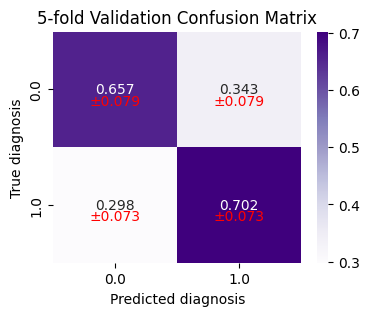

ACCURACY: 0.679±0.069


In [32]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "LR"
PSD_features = "AcrossTrial"

x = np.load(f"Week4_arrays/{PSD_features}_PSDfeatures.npy", allow_pickle=True)
x = x.reshape(190,-1)
print(x.shape)

y = np.load('Week4_arrays/diagnoses.npy', allow_pickle=True)
print(y.shape)

indices = np.load('Week4_arrays/indices.npy')

# x = x[indices]
# y = y[indices]

scores_stats, confusion_matrices_stats, labels, percent_stats, models = predict_ASD_stratkfold(random_state,standardize_all,k,C,x,y,model)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

(190, 163840)
(190,)
[0. 1.]


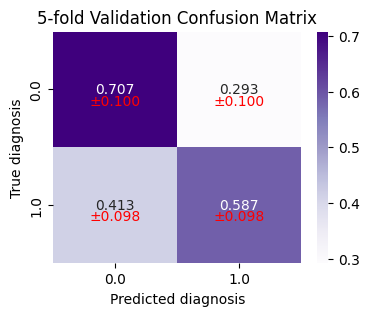

ACCURACY: 0.647±0.070


In [39]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "LR"
PSD_features = "64trial"

x = np.load(f"Week4_arrays/{PSD_features}_PSDfeatures.npy", allow_pickle=True)
x = x.reshape(190,-1)
print(x.shape)

y = np.load('Week4_arrays/diagnoses.npy', allow_pickle=True)
print(y.shape)

indices = np.load('Week4_arrays/indices.npy')

x = x[indices]
y = y[indices]

scores_stats, confusion_matrices_stats, labels, percent_stats= predict_ASD_stratkfold(random_state,standardize_all,k,C,x,y,model)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

## With 5x shuffling and 5x cross-val

In [8]:
# indices = [np.random.permutation(190) for _ in range(5)]
# np.save('5indices.npy', indices)

In [9]:


def plot_confusion_matrix(stats, labels, title):
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(stats[0], annot=True, fmt=".3f", cmap="Purples", xticklabels=labels, yticklabels=labels)
    
    for i in range(stats[0].shape[0]):
        for j in range(stats[1].shape[1]):
            text1= ax.text(j+0.5, i+0.6, f"±{stats[1][i, j]:.3f}", 
                    ha='center', va='center', color='red', fontsize=10)
#             text2 = ax.text(j+0.5, i+0.8, f"{percent_stats[0][i, j]:.3f}±{percent_stats[1][i, j]:.3f}%", 
#                     ha='center', va='center', color='limegreen', fontsize=10)
            

    plt.xlabel('Predicted diagnosis')
    plt.ylabel('True diagnosis')
    plt.title(title)
    plt.show()

In [10]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def predict_ASD_shufflestrat_kfold(random_state, standardize_all, k, C, x, y, model, indices):
    kf = KFold(n_splits=k, shuffle=False) # indices controls shuffling
    
    if model == "RF":
        pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state, bootstrap=False))
    elif model == "LR":
        pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
    elif model == "SVC":
        pipeline = make_pipeline(StandardScaler(), SVC(random_state=random_state, probability=True))
    elif model == "ANN":
        pipeline = make_pipeline(StandardScaler(), ann_model)
    modelweights = []
        
    
    if standardize_all == False:
        pipeline = make_pipeline(RandomForestClassifier(random_state=random_state)) if model == "RF" else pipeline
        pipeline = make_pipeline(LogisticRegression(random_state=random_state)) if model == "LR" else pipeline
        pipeline = make_pipeline(SVC(random_state=random_state)) if model == "SVC" else pipeline
    
    all_scores = []
    all_confusion_matrices = []
    all_confusion_matrices_percent = []
    models = []
    
    f1_scores = []
    precisions = []
    recalls = []
    specificities = []
    aurocs = []
    auprcs = []

    for idx in indices:
        x_shuffled = x[idx]
        y_shuffled = y[idx]

        scores = cross_val_score(pipeline, x_shuffled, y_shuffled, cv=kf, scoring='accuracy')
        all_scores.append(scores)
        
        y_pred = cross_val_predict(pipeline, x_shuffled, y_shuffled, cv=kf)
        labels = np.unique(y_shuffled)
        
        confusion_matrices = []
        confusion_matrices_percent = []

        for train_index, test_index in kf.split(x_shuffled, y_shuffled):
            x_train, x_test = x_shuffled[train_index], x_shuffled[test_index]
            y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]

            pipeline.fit(x_train, y_train)
            y_pred_fold = pipeline.predict(x_test)

            cm = confusion_matrix(y_test, y_pred_fold, labels=labels)
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            confusion_matrices.append(cm)
            confusion_matrices_percent.append(cm_percent)
            
            f1_scores.append(f1_score(y_test, y_pred_fold, average='binary'))
            precisions.append(precision_score(y_test, y_pred_fold, average='binary'))
            recalls.append(recall_score(y_test, y_pred_fold, average='binary'))

            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)
            specificities.append(specificity)
            
            if len(np.unique(y_test)) > 1:  # Check if there is more than one class
                y_probs = pipeline.predict_proba(x_test)[:, 1]
                aurocs.append(roc_auc_score(y_test, y_probs))
                auprcs.append(average_precision_score(y_test, y_probs))
            
            if model == "RF":
                models.append(pipeline.named_steps['randomforestclassifier'])
            elif model == "LR":
                models.append(pipeline.named_steps['logisticregression'])
                modelweights.append(pipeline.named_steps['logisticregression'].coef_.flatten())
        
        all_confusion_matrices.append(confusion_matrices)
        all_confusion_matrices_percent.append(confusion_matrices_percent)
    
    scores_stats = (np.mean(all_scores), np.std(all_scores))
    confusion_matrices_stats = (np.mean([np.mean(cm, axis=0) for cm in all_confusion_matrices], axis=0), 
                                np.std([np.std(cm, axis=0) for cm in all_confusion_matrices], axis=0))
    percent_stats = (np.mean([np.mean(cm, axis=0) for cm in all_confusion_matrices_percent], axis=0), 
                     np.std([np.std(cm, axis=0) for cm in all_confusion_matrices_percent], axis=0))

    metrics_stats = {
        'accuracy': (np.mean(all_scores), np.std(all_scores)),
        'f1_score': (np.mean(f1_scores), np.std(f1_scores)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'specificity': (np.mean(specificities), np.std(specificities)),
        'auroc': (np.mean(aurocs), np.std(aurocs)),
        'auprc': (np.mean(auprcs), np.std(auprcs))
    }
    
    all_metrics = {
        'all_accuracy': all_scores,
        'all_f1_score': f1_scores,
        'all_precision': precisions,
        'all_recall': recalls,
        'all_specificity': specificities,
        'all_auroc': aurocs,
        'all_auprc': auprcs
    }
    
    metrics_stats = round_metrics_dict(metrics_stats, 3)

    return all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics, np.array(modelweights)

def round_metrics_dict(d, decimals=3):
        return {k: (round(v[0], decimals), round(v[1], decimals)) for k, v in d.items()}


(190, 2, 4, 128, 5)
(190, 5120)
(190,)


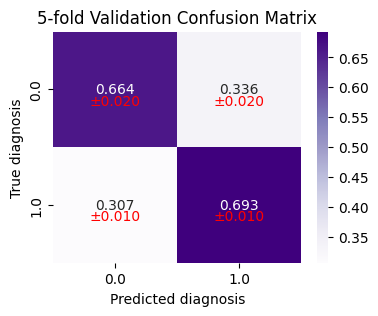

ACCURACY: 0.678±0.083


In [15]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "LR"
PSD_features = "AcrossTrial"

x = np.load(f"/projectnb/ace-ig/michelle/micsu/NEW_INPUTS/{PSD_features}_PSDfeatures.npy", allow_pickle=True)


print(x.shape)
x = x.reshape(190, -1)

# x = np.load("Week4_arrays/trial_mean_PSDs.npy")[:,:128,]
# x = x.reshape(190,-1)

print(x.shape)

#sexs = np.load('/projectnb/ace-ig/michelle/micsu/NEW_INPUTS/sexs.npy', allow_pickle=True)

y = np.load('/projectnb/ace-ig/michelle/micsu/NEW_INPUTS/diagnoses.npy', allow_pickle=True)

print(y.shape)

indices = np.load('/projectnb/ace-ig/michelle/micsu/NEW_INPUTS/5indices.npy',allow_pickle=True)

all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics, weights = predict_ASD_shufflestrat_kfold(random_state,standardize_all,k,C,x,y,model, indices)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

In [26]:
all_metrics['all_accuracy']

[array([0.63157895, 0.60526316, 0.65789474, 0.68421053, 0.68421053]),
 array([0.81578947, 0.73684211, 0.5       , 0.68421053, 0.60526316]),
 array([0.73684211, 0.73684211, 0.60526316, 0.60526316, 0.76315789]),
 array([0.68421053, 0.71052632, 0.57894737, 0.81578947, 0.78947368]),
 array([0.81578947, 0.68421053, 0.63157895, 0.63157895, 0.55263158])]

In [30]:
np.argmax(all_metrics['all_auroc'])

20

In [38]:
all_metrics['all_auroc']

[0.7246376811594203,
 0.7036011080332409,
 0.7329545454545454,
 0.7617728531855956,
 0.6834733893557423,
 0.8055555555555556,
 0.7922437673130194,
 0.6388888888888888,
 0.811111111111111,
 0.6974789915966386,
 0.8065476190476191,
 0.8375350140056023,
 0.7797619047619048,
 0.6038781163434904,
 0.7840909090909092,
 0.8028985507246377,
 0.7619047619047619,
 0.6055555555555556,
 0.8587257617728532,
 0.7871148459383754,
 0.8627450980392156,
 0.7728531855955678,
 0.7388888888888889,
 0.7217391304347825,
 0.6231884057971014]

## Mean and STD separately

In [ ]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "LR"
name = "LR_STDAcross"

x = np.load(f"NEW_INPUTS/STD_AcrossFeatures.npy", allow_pickle=True)


print(x.shape)
x = x.reshape(190, -1)

# x = np.load("Week4_arrays/trial_mean_PSDs.npy")[:,:128,]
# x = x.reshape(190,-1)

print(x.shape)

sexs = np.load('NEW_INPUTS/sexs.npy', allow_pickle=True)

y = np.load('NEW_INPUTS/diagnoses.npy', allow_pickle=True)

print(y.shape)

indices = np.load('NEW_INPUTS/5indices.npy',allow_pickle=True)

all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics = predict_ASD_shufflestrat_kfold(random_state,standardize_all,k,C,x,y,model, indices)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

joblib.dump(models, f"NEW_RESULTS/{name}.pkl")
np.save(f"NEW_RESULTS/{name}_scores", all_scores)
np.savez(f'NEW_RESULTS/{name}_allmetrics.npz', **all_metrics)

## M/F separately

In [6]:
root = '/projectnb/ace-ig/michelle/MFseparate/'

(104, 2, 4, 128, 5)
(104, 5120)


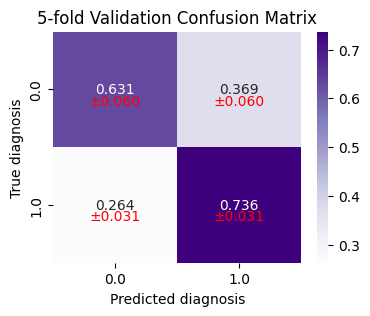

ACCURACY: 0.683±0.076


In [24]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "LR"
PSD_features = "AcrossTrial"
name = "LR_AcrossTrial_Male"

x = np.load(root+"NEW_INPUTS/M_AcrossFeatures.npy", allow_pickle=True) #NEW, do M_Across.... or F_Across..

print(x.shape)
x = x.reshape(104, -1)
print(x.shape)

sexs = np.load(root+'NEW_INPUTS/sexs.npy', allow_pickle=True)
y = np.load(root+'NEW_INPUTS/diagnoses.npy', allow_pickle=True)[sexs==1] ####NEW, change to sexs==0 or 1

indices = np.load(root+'NEW_INPUTS/M_5indices.npy',allow_pickle=True) #Do F_... or M_...

all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics, weights = predict_ASD_shufflestrat_kfold(random_state,standardize_all,k,C,x,y,model, indices)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

np.save("/projectnb/ace-ig/deeksha/"+name+"_weights.npy", weights)
#joblib.dump(models, root+"NEW_RESULTS/"+name+".pkl")
#np.save(root+f"NEW_RESULTS/{name}_scores", all_scores)
#np.savez(root+f'NEW_RESULTS/{name}_allmetrics.npz', **all_metrics)

In [26]:
weights.shape

(25, 5120)

## Save model

In [ ]:
# random_state=35
# standardize_all=True
# k=5
# C=0.01
# model = "RF"

# # PSD_features = "Original"
# # x = np.load("Week4_arrays/trial_mean_PSDs.npy")[:,:128,]
# # print(x.shape)
# # x = x.reshape(190,-1)
# # print(x.shape)

# # PSD_features = "ByElectrode"
# # x = np.load("Week4_arrays/128by4.npy")[:,:128,]
# # print(x.shape)
# # x = x.reshape(190,-1)
# # print(x.shape)

# PSD_features = "PLV"
# x = np.load("Week4_arrays/PLV.npy")[:,:128,]
# print(x.shape)
# x = x.reshape(190,-1)
# print(x.shape)

# y = np.load('Week4_arrays/diagnoses.npy', allow_pickle=True)
# print(y.shape)

# indices = np.load('Week4_arrays/5indices.npy',allow_pickle=True)

# all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics = predict_ASD_shufflestrat_kfold(random_state,standardize_all,k,C,x,y,model, indices)


# plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
# print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

In [66]:
# # for i in range(len(models)):
# #     joblib.dump(models[i], f"new_models/{model}_{PSD_features}_{i}")
# joblib.dump(models, f"new_models/{model}_{PSD_features}.pkl")
# np.save(f"new_models/{model}_{PSD_features}_scores", all_scores)
# np.savez(f'new_models/{model}_{PSD_features}_allmetrics.npz', **all_metrics)


In [171]:
# df = pd.read_csv('NEW_RESULTS/FINALRESULTS.csv')

In [175]:
# model_details = {
#     'model_name': model,
#     'feature_type': PSD_features
# }
# ^^ for og ones without male and female


model_details = {
    'model_name': name,
    'feature_type': PSD_features
}

new_row = {**metrics_stats, **model_details, **all_metrics}
df = df._append(new_row, ignore_index=True)

In [176]:
# df.loc[11, 'feature_type'] = 'PLV'
# df = df.drop(index=111)
df

,accuracy,f1_score,precision,recall,specificity,auroc,auprc,model_name,feature_type,all_accuracy,all_f1_score,all_precision,all_recall,all_specificity,all_auroc,all_auprc
0,"(0.673, 0.069)","(0.649, 0.075)","(0.697, 0.102)","(0.625, 0.112)","(0.729, 0.103)","(0.755, 0.078)","(0.753, 0.102)",LR,64trial,"[array([0.71052632, 0.57894737, 0.71052632, 0....","[0.7441860465116279, 0.5, 0.7027027027027026, ...","[0.8, 0.6153846153846154, 0.6190476190476191, ...","[0.6956521739130435, 0.42105263157894735, 0.81...","[0.7333333333333333, 0.7368421052631579, 0.636...","[0.7594202898550724, 0.7229916897506925, 0.795...","[0.8310523658036825, 0.7407918027948872, 0.746..."
1,"(0.615, 0.099)","(0.599, 0.108)","(0.621, 0.087)","(0.603, 0.16)","(0.643, 0.118)","(0.695, 0.107)","(0.697, 0.099)",RF,64trial,"[array([0.39473684, 0.63157895, 0.63157895, 0....","[0.4390243902439025, 0.5882352941176471, 0.611...","[0.5, 0.6666666666666666, 0.55, 0.666666666666...","[0.391304347826087, 0.5263157894736842, 0.6875...","[0.4, 0.7368421052631579, 0.5909090909090909, ...","[0.4869565217391304, 0.7437673130193906, 0.717...","[0.652410338916835, 0.7582651743688447, 0.7048..."
2,"(0.678, 0.083)","(0.678, 0.083)","(0.674, 0.101)","(0.693, 0.108)","(0.664, 0.123)","(0.748, 0.073)","(0.751, 0.086)",LR,AcrossTrial,"[array([0.63157895, 0.60526316, 0.65789474, 0....","[0.7083333333333334, 0.5454545454545454, 0.606...","[0.68, 0.6428571428571429, 0.5882352941176471,...","[0.7391304347826086, 0.47368421052631576, 0.62...","[0.4666666666666667, 0.7368421052631579, 0.681...","[0.7246376811594203, 0.7036011080332409, 0.732...","[0.8511925156447359, 0.7076011305416339, 0.668..."
3,"(0.66, 0.085)","(0.646, 0.102)","(0.665, 0.112)","(0.649, 0.147)","(0.681, 0.121)","(0.742, 0.082)","(0.744, 0.089)",RF,AcrossTrial,"[array([0.65789474, 0.57894737, 0.65789474, 0....","[0.6976744186046512, 0.4666666666666667, 0.648...","[0.75, 0.6363636363636364, 0.5714285714285714,...","[0.6521739130434783, 0.3684210526315789, 0.75,...","[0.6666666666666666, 0.7894736842105263, 0.590...","[0.7014492753623188, 0.6966759002770083, 0.742...","[0.8068809526215612, 0.7165280639995903, 0.708..."
4,"(0.608, 0.06)","(0.597, 0.088)","(0.601, 0.082)","(0.604, 0.117)","(0.61, 0.085)","(0.648, 0.07)","(0.678, 0.084)",LR,MeanEEG,"[array([0.60526316, 0.60526316, 0.63157895, 0....","[0.6511627906976744, 0.5161290322580646, 0.611...","[0.7, 0.6666666666666666, 0.55, 0.571428571428...","[0.6086956521739131, 0.42105263157894735, 0.68...","[0.6, 0.7894736842105263, 0.5909090909090909, ...","[0.5913043478260869, 0.670360110803324, 0.6875...","[0.7541263588600421, 0.6962347983400614, 0.670..."
5,"(0.614, 0.068)","(0.589, 0.076)","(0.626, 0.095)","(0.571, 0.109)","(0.662, 0.115)","(0.672, 0.092)","(0.693, 0.088)",RF,MeanEEG,"[array([0.5 , 0.57894737, 0.57894737, 0....","[0.4571428571428571, 0.5789473684210527, 0.555...","[0.6666666666666666, 0.5789473684210527, 0.5, ...","[0.34782608695652173, 0.5789473684210527, 0.62...","[0.7333333333333333, 0.5789473684210527, 0.545...","[0.5173913043478261, 0.6509695290858727, 0.680...","[0.689595348508392, 0.6792787822199586, 0.6925..."
6,"(0.648, 0.081)","(0.621, 0.088)","(0.666, 0.11)","(0.589, 0.098)","(0.71, 0.101)","(0.675, 0.073)","(0.704, 0.092)",LR,Original,"[array([0.68421053, 0.71052632, 0.52631579, 0....","[0.7, 0.6666666666666667, 0.5, 0.7894736842105...","[0.8235294117647058, 0.7857142857142857, 0.45,...","[0.6086956521739131, 0.5789473684210527, 0.562...","[0.8, 0.8421052631578947, 0.5, 0.7894736842105...","[0.7043478260869565, 0.667590027700831, 0.6022...","[0.8185938517792866, 0.7609872137871083, 0.552..."
7,"(0.645, 0.073)","(0.618, 0.088)","(0.662, 0.109)","(0.592, 0.114)","(0.705, 0.089)","(0.687, 0.09)","(0.716, 0.096)",RF,Original,"[array([0.68421053, 0.63157895, 0.65789474, 0....","[0.6842105263157895, 0.6111111111111113, 0.648...","[0.8666666666666667, 0.6470588235294118, 0.571...","[0.5652173913043478, 0.5789473684210527, 0.75,...","[0.8666666666666667,

In [177]:
df.to_csv('NEW_RESULTS/FINALRESULTS.csv', index=False)

In [178]:
grouped_df = df.groupby(['feature_type', 'model_name']).sum().reset_index()
grouped_df

,feature_type,model_name,accuracy,f1_score,precision,recall,specificity,auroc,auprc,all_accuracy,all_f1_score,all_precision,all_recall,all_specificity,all_auroc,all_auprc
0,64trial,LR,"(0.673, 0.069)","(0.649, 0.075)","(0.697, 0.102)","(0.625, 0.112)","(0.729, 0.103)","(0.755, 0.078)","(0.753, 0.102)","[array([0.71052632, 0.57894737, 0.71052632, 0....","[0.7441860465116279, 0.5, 0.7027027027027026, ...","[0.8, 0.6153846153846154, 0.6190476190476191, ...","[0.6956521739130435, 0.42105263157894735, 0.81...","[0.7333333333333333, 0.7368421052631579, 0.636...","[0.7594202898550724, 0.7229916897506925, 0.795...","[0.8310523658036825, 0.7407918027948872, 0.746..."
1,64trial,RF,"(0.615, 0.099)","(0.599, 0.108)","(0.621, 0.087)","(0.603, 0.16)","(0.643, 0.118)","(0.695, 0.107)","(0.697, 0.099)","[array([0.39473684, 0.63157895, 0.63157895, 0....","[0.4390243902439025, 0.5882352941176471, 0.611...","[0.5, 0.6666666666666666, 0.55, 0.666666666666...","[0.391304347826087, 0.5263157894736842, 0.6875...","[0.4, 0.7368421052631579, 0.5909090909090909, ...","[0.4869565217391304, 0.7437673130193906, 0.717...","[0.652410338916835, 0.7582651743688447, 0.7048..."
2,AcrossTrial,ANN,"(0.654, 0.088)","(0.682, 0.099)","(0.65, 0.108)","(0.751, 0.156)","(0.59, 0.16)","(0.721, 0.095)","(0.709, 0.084)","[array([0.63157895, 0.57894737, 0.60526316, 0....","[0.7547169811320755, 0.5405405405405406, 0.647...","[0.6666666666666666, 0.5555555555555556, 0.611...","[0.8695652173913043, 0.5263157894736842, 0.687...","[0.3333333333333333, 0.5789473684210527, 0.681...","[0.6115942028985507, 0.6786703601108033, 0.747...","[0.7371114090288945, 0.6982330879877157, 0.688..."
3,AcrossTrial,LR,"(0.678, 0.083)","(0.678, 0.083)","(0.674, 0.101)","(0.693, 0.108)","(0.664, 0.123)","(0.748, 0.073)","(0.751, 0.086)","[array([0.63157895, 0.60526316, 0.65789474, 0....","[0.7083333333333334, 0.5454545454545454, 0.606...","[0.68, 0.6428571428571429, 0.5882352941176471,...","[0.7391304347826086, 0.47368421052631576, 0.62...","[0.4666666666666667, 0.7368421052631579, 0.681...","[0.7246376811594203, 0.7036011080332409, 0.732...","[0.8511925156447359, 0.7076011305416339, 0.668..."
4,AcrossTrial,LR_AcrossTrial_Female,"(0.685, 0.111)","(0.633, 0.117)","(0.684, 0.155)","(0.621, 0.169)","(0.75, 0.154)","(0.759, 0.12)","(0.761, 0.115)","[array([0.77777778, 0.58823529, 0.70588235, 0....","[0.8, 0.5882352941176471, 0.6153846153846154, ...","[0.8, 0.625, 1.0, 0.42857142857142855, 0.66666...","[0.8, 0.5555555555555556, 0.4444444444444444, ...","[0.75, 0.625, 1.0, 0.6666666666666666, 0.81818...","[0.825, 0.7083333333333334, 0.9305555555555556...","[0.8980555555555556, 0.7381063381063382, 0.945..."
5,AcrossTrial,LR_AcrossTrial_Male,"(0.683, 0.076)","(0.706, 0.063)","(0.714, 0.123)","(0.733, 0.126)","(0.635, 0.212)","(0.735, 0.119)","(0.782, 0.109)","[array([0.71428571, 0.66666667, 0.71428571, 0....","[0.75, 0.5882352941176471, 0.7272727272727273,...","[0.8181818181818182, 0.8333333333333334, 0.615...","[0.6923076923076923, 0.45454545454545453, 0.88...","[0.75, 0.9, 0.5833333333333334, 0.625, 0.45454...","[0.6923076923076923, 0.7454545454545455, 0.759...","[0.8127332634685573, 0.7540873127560433, 0.760..."
6,AcrossTrial,LR_MeanAcross,"(0.654, 0.062)","(0.651, 0.062)","(0.655, 0.107)","(0.663, 0.087)","(0.651, 0.124)","(0.732, 0.074)","(0.737, 0.086)","[[0.6052631578947368, 0.6052631578947368, 0.65...","[0.6666666666666666, 0.5454545454545454, 0.628...","[0.6818181818181818, 0.6428571428571429, 0.578...","[0.6521739130434783, 0.47368421052631576, 0.68...","[0.5333333333333333, 0.7368421052631579, 0.636...","[0.672463768115942, 0.6952908587257618, 0.7017...","[0.8154240922641086, 0.7101165512805379, 0.622..."
7,AcrossTrial,LR_STDAcross,"(0.637, 0.079)","(0.629, 0.086)","(0.634, 0.092)","(0.637, 0.119)","(0.637, 0.113)","(0.707, 0.086)","(0.712, 0.099)","[[0.6052631578947368, 0.5263157894736842, 0.65...","[0.6666666666666666, 0.4375, 0.606060606060606...","[0.6818181818181818, 0.5384615384615384, 0.5

# Get PLV features and train with PLV features

In [183]:
root = "/projectnb/ace-ig/deeksha/day-2/processed/"
filename = "580.03_processed.set"
raw = mne.io.read_epochs_eeglab(root+filename)
full_eeg = raw.get_data()[:,:128,:]
# #full_eeg: 96 2-second trials/windows, 128 channels + 1 base channel, 2.048 sec*500 Hz = 1024 samples)
# trials_64_eeg = full_eeg[:64]



Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/580.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [184]:
full_eeg.shape

(128, 128, 1024)

In [188]:

plv = spectral_connectivity_epochs(
    full_eeg[:64], 
    sfreq=500,
    method="plv",
    fmin=freqs[0], 
    fmax=freqs[1], 
)


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 8128 connections
    using t=0.000s..2.046s for estimation (1024 points)
    frequencies: 8.3Hz..11.7Hz (8 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLV
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral 

In [201]:
plv.get_data().shape

(16384, 6)

In [189]:
np.where(plv.get_data()!=0)[0].size/(2*4)

8128.0

In [150]:
np.unique(np.where(plv.get_data()!=0)[0]).size

8128

In [126]:
128*127/2

8128.0

In [160]:
np.where(plv.get_data()!=0)[0]

array([  128,   128,   128, ..., 16382, 16382, 16382])

In [173]:
plv.get_data()[np.unique(np.where(plv.get_data()!=0)[0])].shape

(8128, 8)

In [ ]:
PLV = np.zeros((190, 5, 8128))

band_start = [1, 4, 8, 13, 30, 50]

i = 0
for filename in os.listdir(root):
    raw = mne.io.read_epochs_eeglab(root+filename)
    full_eeg = raw.get_data()[:,:128,:]
    if full_eeg.shape[0]<64:
        continue
    
    for j in range(5):
        plv = spectral_connectivity_epochs(
            full_eeg, 
            sfreq=500,
            method="plv",
            fmin=band_start[j], 
            fmax=band_start[j+1], 
        )
        
        flattened = plv.get_data()[np.unique(np.where(plv.get_data()!=0)[0])].mean(axis=1)
        
        PLV[i,j,:]=flattened
    i+=1

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/780.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 8128 connections
    using t=0.000s..2.046s for estimation (1024 points)
    frequencies: 1.5Hz..3.9Hz (6 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLV
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spe

In [1]:
PLV

NameError: name 'PLV' is not defined

In [5]:
x = np.load('Week4_arrays/PLV.npy',allow_pickle=True)

In [7]:
x==0

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [Fal

In [5]:
x = np.load("Week4_arrays/trial_mean_PSDs.npy")[:,:128,]

In [6]:
x.shape

(190, 128, 257)

# Feature importance

In [8]:
model_name = "LR"
PSD_features = "AcrossTrial"
models = joblib.load(f"NEW_RESULTS/new_models/{model_name}_{PSD_features}.pkl")
accuracies = np.load(f"NEW_RESULTS/new_models/{model_name}_{PSD_features}_scores.npy")

In [9]:
all_weights = np.zeros((25, 2, 4, 128, 5))
for i in range(25):
    flat_LR_weights = np.abs(models[i].coef_.flatten())
    LR_weights = np.reshape(flat_LR_weights, (2, 4, 128, 5))
    all_weights[i] = LR_weights
modelmean_weights = np.mean(all_weights, axis=0)
flat_modelmean_weights = modelmean_weights.flatten()
modelstd_weights = np.std(all_weights, axis=0)

In [10]:
modelmean_weights.shape

(2, 4, 128, 5)

In [11]:
twohundred_weights = np.reshape(all_weights, (200, 128, 5))

## Top 5%

In [12]:
percent = 5
num_features = modelmean_weights.size
top_num = int(num_features*percent/100)
sorted_indices = np.argsort(-flat_modelmean_weights)
top_indices_flat = sorted_indices[:top_num]
top_indices = np.unravel_index(top_indices_flat, modelmean_weights.shape)

In [13]:
top_indices_arr = np.array(top_indices)
top_indices_arr

array([[  1,   1,   1, ...,   0,   1,   1],
       [  2,   3,   2, ...,   2,   3,   3],
       [ 92,  82, 116, ..., 111,  93, 121],
       [  1,   1,   0, ...,   0,   3,   1]])

In [14]:
def count_values(array, feature_type):
    unique, counts = np.unique(array, return_counts=True)
    
    df = pd.DataFrame({
        f'{feature_type}': unique,
        'count': counts
    })
    df_sorted = df.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return df_sorted

In [15]:
feature_types = ['across_trial_feature', 'band_feature', 'electrode', 'band']
x = []
for i in range(len(top_indices)):
    x.append(count_values(top_indices[i], feature_types[i]))
    
# mean, std
# mean, std, skew, kurtosis
# electrode
# band

#STD OF SKEW AND KURTOSIS WITHIN BAND, LOWER FREQ BANDS

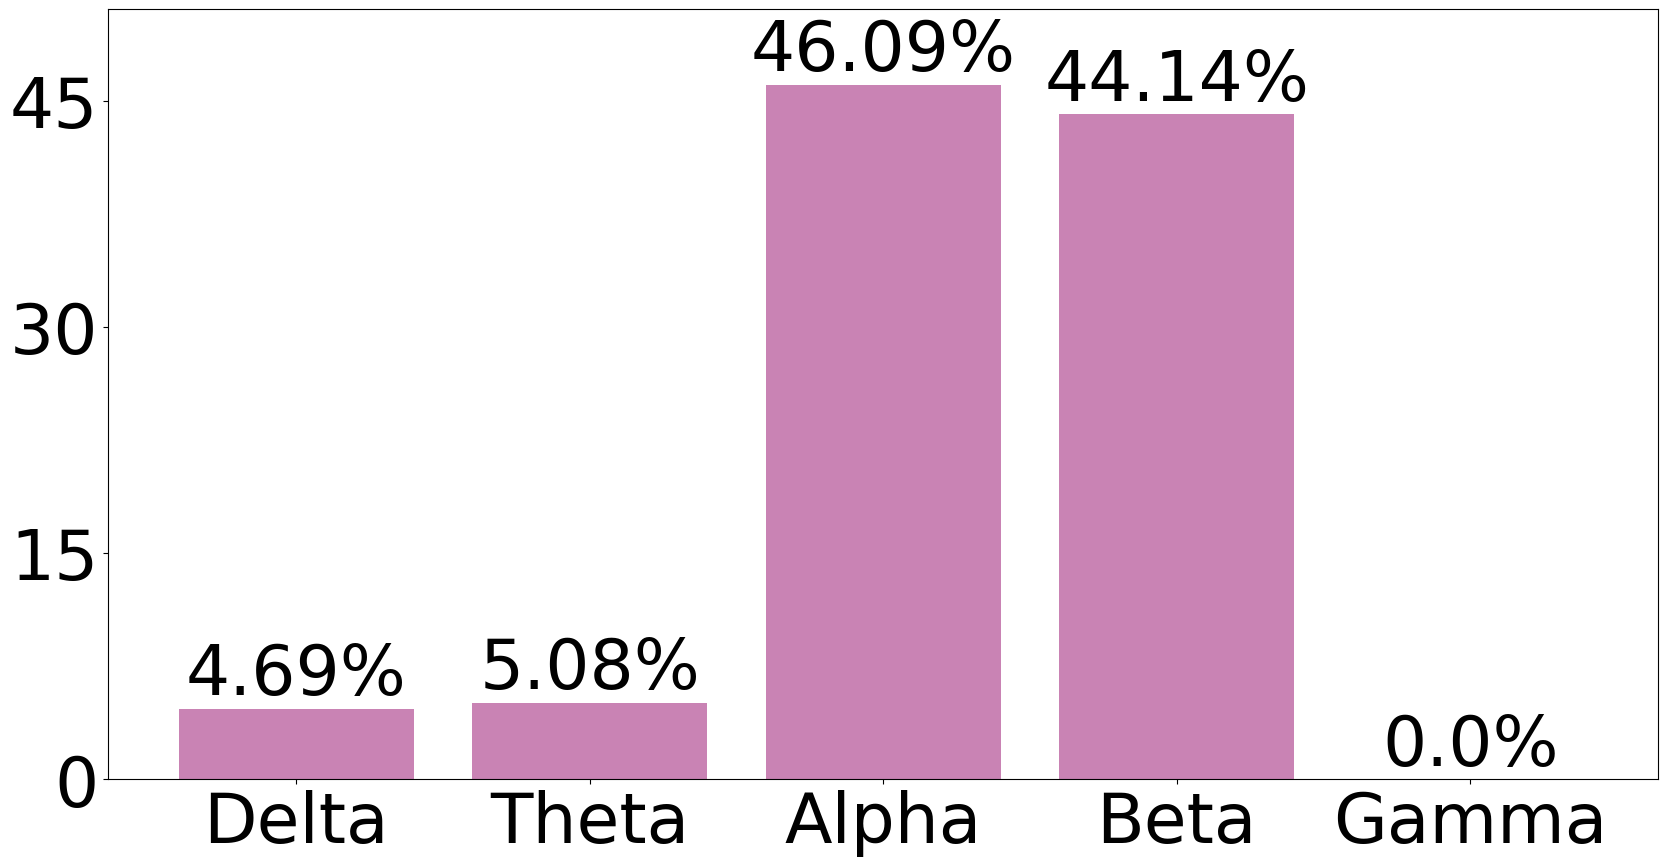

In [16]:
df = x[1]
names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
num_to_name = {i: name for i, name in enumerate(names)}
df.loc[4] = [4, 0]
df['band_feature_name'] = df['band_feature'].map(num_to_name)
df['band_feature_name'] = pd.Categorical(df['band_feature_name'], categories=names, ordered=True)
df = df.sort_values('band_feature_name')
df['band_percent'] = df['count']/top_num*100
band_percents = df['band_percent'].to_numpy()

plt.figure(figsize=(20, 10))
bars = plt.bar(df['band_feature_name'], (df['band_percent']).round(2), color='#c983b4')
# plt.title(f'Frequency Band of Top {percent}% Features',fontsize=20)
# plt.xlabel('Frequency band', fontsize=15)
# plt.ylabel(f'Percent of Top {percent}% Important Features in Given Band',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=50)  # Major ticks
plt.ylim(0, df['band_percent'].max() + 5)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}%', ha='center', va='bottom', fontsize=50)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(15))
plt.show()

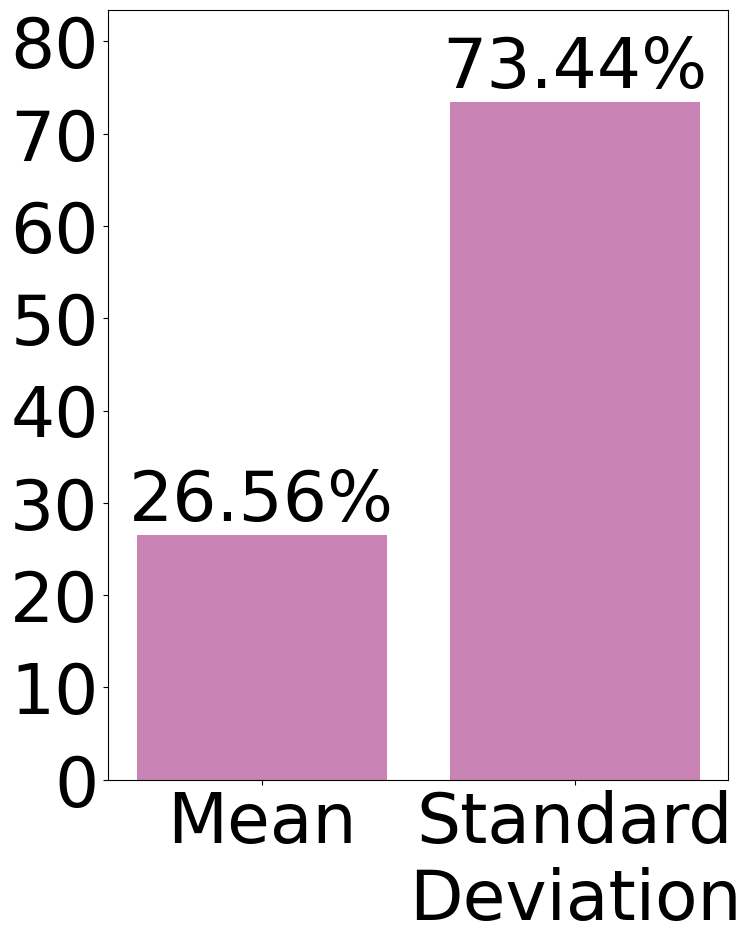

In [17]:
df = x[0]
names = ["Mean", "Standard\nDeviation"]
num_to_name = {i: name for i, name in enumerate(names)}
df['across_trial_feature_name'] = df['across_trial_feature'].map(num_to_name)
df['across_trial_feature_name'] = pd.Categorical(df['across_trial_feature_name'], categories=names, ordered=True)
df = df.sort_values('across_trial_feature_name')
df['feature_percent'] = df['count']/top_num*100
band_percents = df['feature_percent'].to_numpy()

plt.figure(figsize=(8, 10))
bars = plt.bar(df['across_trial_feature_name'], (df['feature_percent']).round(2), color='#c983b4')
# plt.title(f'Across-trial Feature Type of {percent}% Features', fontsize = 20)
# plt.xlabel('Across-trial Feature Type', fontsize=15)
# plt.ylabel(f'Percent of Top {percent}% Important Features\n in Given Feature Type', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=50)  # Major ticks
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}%', ha='center', va='bottom', fontsize=50)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
plt.ylim(0, df['feature_percent'].max() + 10)

plt.show()

In [18]:
x[0]

,across_trial_feature,count,across_trial_feature_name
0,1,188,Standard\nDeviation
1,0,68,Mean


In [19]:
df = x[2]
#load a single processed EEG data- 
root = "/projectnb/ace-ig/deeksha/day-2/processed/"
filename = "580.03_processed.set"

#load data
raw = mne.io.read_epochs_eeglab(root+filename)
names = raw.info["ch_names"]
num_to_name = {i: name for i, name in enumerate(names)}
electrode_counts = np.zeros(129, dtype=int)
electrode_counts[df['electrode']] = df['count']
electrode_percents = (electrode_counts / top_num) * 100
electrode_percents.shape

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/580.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.


(129,)

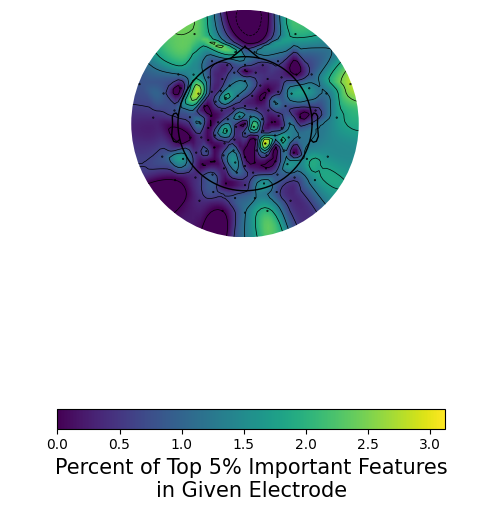

In [20]:
fig, axs = plt.subplots(2, figsize=(5, 5))

vmin = np.min(electrode_percents)
vmax = np.max(electrode_percents)
im, _ = mne.viz.plot_topomap(electrode_percents, pos=raw.info, cmap='viridis', axes=axs[0], show=False, vlim=((vmin,vmax)))

key = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.08, pad=0.04)
key.set_label(f"Percent of Top {percent}% Important Features\nin Given Electrode", fontsize=15)
plt.tight_layout()
axs[1].axis('off')
    
plt.tight_layout()
plt.show()

## Model weight head plots

In [21]:
x = modelmean_weights.reshape(8,128,5).transpose(1, 2, 0)
electrode_band_meancoef = np.sum(x, axis=2) #changed from mean to SUM
# electrode_band_stdcoef = np.std(x, axis=2)
electrode_band_meancoef.shape
electrode_band_sumcoef = electrode_band_meancoef

In [22]:
root = "/projectnb/ace-ig/deeksha/day-2/processed/"
filename = "580.03_processed.set"
raw = mne.io.read_epochs_eeglab(root+filename)

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/580.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [23]:
# fig, ax = plt.subplots()

# feat_importance_alpha = np.append(electrode_band_meancoef[:,1], 0)
# mne.viz.plot_topomap(feat_importance_alpha, raw.info, show=True, axes=ax)

# plt.show()


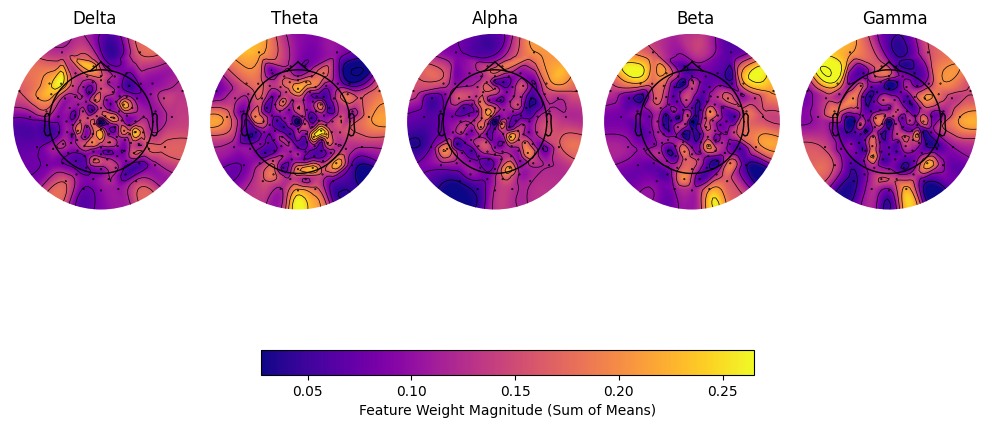

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

vmin, vmax = np.min(electrode_band_meancoef), np.max(electrode_band_meancoef)


for band in range(5):
    feat_importance = np.append(electrode_band_meancoef[:,band], 0)
    mne.viz.plot_topomap(feat_importance, pos=raw.info, cmap='plasma', axes=axs[0,band], show=False, vlim=((vmin,vmax)))

for band in range(5):
    fig.text((band+0.5)/5, 1, f'{band_names[band]}', ha='center', va='center', fontsize=12)

key = fig.colorbar(axs[0, 0].images[0], ax=axs, orientation='horizontal', fraction=0.08, pad=0.04)
key.set_label("Feature Weight Magnitude (Sum of Means)")

for i in range(5):
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# Significance tests

## 1-sample t-tests

In [249]:
twohundred_weights.shape

(200, 128, 5)

In [250]:
t_stats = np.zeros((128, 5))
p_values = np.zeros((128, 5))

In [251]:
for i in range(128):
    for j in range(5):
        t_stat, p_val = ttest_1samp(twohundred_weights[:, i, j], 0, alternative='greater')
        t_stats[i, j] = t_stat
        p_values[i, j] = p_val


In [253]:
print(np.mean(p_values))

8.53743908781766e-19


## GOF tests

In [69]:
band_percents

array([ 4.6875  ,  5.078125, 46.09375 , 44.140625,  0.      ])

In [70]:
electrode_percents

array([0.      , 0.390625, 0.390625, 0.390625, 0.390625, 0.390625,
       1.5625  , 0.78125 , 0.390625, 0.390625, 1.171875, 1.171875,
       0.390625, 1.171875, 0.78125 , 0.      , 0.390625, 0.78125 ,
       1.171875, 1.953125, 1.953125, 0.390625, 0.390625, 0.78125 ,
       0.78125 , 0.78125 , 0.390625, 0.78125 , 0.390625, 0.78125 ,
       0.390625, 1.5625  , 2.734375, 0.      , 0.      , 0.390625,
       1.953125, 0.      , 0.78125 , 1.171875, 0.      , 0.78125 ,
       0.78125 , 0.78125 , 0.      , 0.390625, 0.      , 0.78125 ,
       0.390625, 0.390625, 0.78125 , 0.      , 0.390625, 0.390625,
       0.78125 , 0.78125 , 1.5625  , 0.      , 0.      , 0.78125 ,
       1.171875, 0.      , 0.      , 0.390625, 0.78125 , 0.390625,
       1.5625  , 0.390625, 0.78125 , 0.      , 1.171875, 0.390625,
       0.      , 0.78125 , 0.390625, 0.390625, 0.      , 0.390625,
       0.      , 2.34375 , 1.171875, 1.171875, 1.5625  , 0.      ,
       0.78125 , 3.125   , 0.390625, 1.953125, 0.78125 , 0.781

In [74]:
def chigoftest(data):
    unique, counts = np.unique(data, return_counts=True)
    observed_frequencies = dict(zip(unique, counts))
    observed_frequencies = dict(sorted(observed_frequencies.items()))
    observed_frequencies_array = np.array(list(observed_frequencies.values()))
    total_count = len(data)
    num_groups = len(observed_frequencies)
    expected_frequencies = np.full(num_groups, total_count / num_groups)

    chi2_stat, p_value = chisquare(f_obs=observed_frequencies_array, f_exp=expected_frequencies)

    print(f"Observed frequencies:\n{observed_frequencies}")
    print(f"Expected frequencies:\n{expected_frequencies}")
    print(f"Chi-square statistic: {chi2_stat}")
    print(f"P-value: {p_value}")

In [79]:
chigoftest(top_indices[2])

Observed frequencies:
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 4, 7: 2, 8: 1, 9: 1, 10: 3, 11: 3, 12: 1, 13: 3, 14: 2, 16: 1, 17: 2, 18: 3, 19: 5, 20: 5, 21: 1, 22: 1, 23: 2, 24: 2, 25: 2, 26: 1, 27: 2, 28: 1, 29: 2, 30: 1, 31: 4, 32: 7, 35: 1, 36: 5, 38: 2, 39: 3, 41: 2, 42: 2, 43: 2, 45: 1, 47: 2, 48: 1, 49: 1, 50: 2, 52: 1, 53: 1, 54: 2, 55: 2, 56: 4, 59: 2, 60: 3, 63: 1, 64: 2, 65: 1, 66: 4, 67: 1, 68: 2, 70: 3, 71: 1, 73: 2, 74: 1, 75: 1, 77: 1, 79: 6, 80: 3, 81: 3, 82: 4, 84: 2, 85: 8, 86: 1, 87: 5, 88: 2, 89: 2, 92: 3, 93: 1, 94: 2, 95: 4, 96: 3, 97: 5, 98: 4, 99: 4, 101: 4, 102: 1, 104: 2, 105: 3, 106: 4, 107: 3, 108: 3, 109: 1, 110: 1, 111: 1, 112: 4, 113: 1, 115: 2, 116: 3, 118: 7, 119: 3, 120: 4, 121: 4, 122: 1, 124: 2, 125: 5, 126: 6, 127: 3}
Expected frequencies:
[2.48543689 2.48543689 2.48543689 2.48543689 2.48543689 2.48543689
 2.48543689 2.48543689 2.48543689 2.48543689 2.48543689 2.48543689
 2.48543689 2.48543689 2.48543689 2.48543689 2.48543689 2.48543689
 2.48543689 2.48543

In [80]:
chigoftest(top_indices[3])

Observed frequencies:
{0: 69, 1: 70, 2: 54, 3: 26, 4: 37}
Expected frequencies:
[51.2 51.2 51.2 51.2 51.2]
Chi-square statistic: 29.5859375
P-value: 5.942361617860677e-06


In [81]:
chigoftest(top_indices[0])

Observed frequencies:
{0: 68, 1: 188}
Expected frequencies:
[128. 128.]
Chi-square statistic: 56.25
P-value: 6.381783345821795e-14


## 2-sample t-tests

In [89]:
df = pd.read_csv('FINALRESULTS.csv')
df = df[df['feature_type'].isin(['AcrossTrial', 'MeanEEG'])]

df.groupby(['model_name','feature_type']).sum().iloc[:,:7]
df

,accuracy,f1_score,precision,recall,specificity,auroc,auprc,model_name,feature_type,all_accuracy,all_f1_score,all_precision,all_recall,all_specificity,all_auroc,all_auprc
2,"(0.678, 0.083)","(0.678, 0.083)","(0.674, 0.101)","(0.693, 0.108)","(0.664, 0.123)","(0.748, 0.073)","(0.751, 0.086)",LR,AcrossTrial,"[array([0.63157895, 0.60526316, 0.65789474, 0....","[0.7083333333333334, 0.5454545454545454, 0.606...","[0.68, 0.6428571428571429, 0.5882352941176471,...","[0.7391304347826086, 0.47368421052631576, 0.62...","[0.4666666666666667, 0.7368421052631579, 0.681...","[0.7246376811594203, 0.7036011080332409, 0.732...","[0.8511925156447359, 0.7076011305416339, 0.668..."
3,"(0.66, 0.085)","(0.646, 0.102)","(0.665, 0.112)","(0.649, 0.147)","(0.681, 0.121)","(0.742, 0.082)","(0.744, 0.089)",RF,AcrossTrial,"[array([0.65789474, 0.57894737, 0.65789474, 0....","[0.6976744186046512, 0.4666666666666667, 0.648...","[0.75, 0.6363636363636364, 0.5714285714285714,...","[0.6521739130434783, 0.3684210526315789, 0.75,...","[0.6666666666666666, 0.7894736842105263, 0.590...","[0.7014492753623188, 0.6966759002770083, 0.742...","[0.8068809526215612, 0.7165280639995903, 0.708..."
4,"(0.608, 0.06)","(0.597, 0.088)","(0.601, 0.082)","(0.604, 0.117)","(0.61, 0.085)","(0.648, 0.07)","(0.678, 0.084)",LR,MeanEEG,"[array([0.60526316, 0.60526316, 0.63157895, 0....","[0.6511627906976744, 0.5161290322580646, 0.611...","[0.7, 0.6666666666666666, 0.55, 0.571428571428...","[0.6086956521739131, 0.42105263157894735, 0.68...","[0.6, 0.7894736842105263, 0.5909090909090909, ...","[0.5913043478260869, 0.670360110803324, 0.6875...","[0.7541263588600421, 0.6962347983400614, 0.670..."
5,"(0.614, 0.068)","(0.589, 0.076)","(0.626, 0.095)","(0.571, 0.109)","(0.662, 0.115)","(0.672, 0.092)","(0.693, 0.088)",RF,MeanEEG,"[array([0.5 , 0.57894737, 0.57894737, 0....","[0.4571428571428571, 0.5789473684210527, 0.555...","[0.6666666666666666, 0.5789473684210527, 0.5, ...","[0.34782608695652173, 0.5789473684210527, 0.62...","[0.7333333333333333, 0.5789473684210527, 0.545...","[0.5173913043478261, 0.6509695290858727, 0.680...","[0.689595348508392, 0.6792787822199586, 0.6925..."
12,"(0.654, 0.088)","(0.682, 0.099)","(0.65, 0.108)","(0.751, 0.156)","(0.59, 0.16)","(0.721, 0.095)","(0.709, 0.084)",ANN,AcrossTrial,"[array([0.63157895, 0.57894737, 0.60526316, 0....","[0.7547169811320755, 0.5405405405405406, 0.647...","[0.6666666666666666, 0.5555555555555556, 0.611...","[0.8695652173913043, 0.5263157894736842, 0.687...","[0.3333333333333333, 0.5789473684210527, 0.681...","[0.6115942028985507, 0.6786703601108033, 0.747...","[0.7371114090288945, 0.6982330879877157, 0.688..."
13,"(0.659, 0.079)","(0.656, 0.089)","(0.659, 0.101)","(0.679, 0.146)","(0.654, 0.106)","(0.734, 0.087)","(0.743, 0.093)",SVC,AcrossTrial,"[array([0.60526316, 0.57894737, 0.65789474, 0....","[0.6511627906976745, 0.5555555555555556, 0.648...","[0.7, 0.5882352941176471, 0.5714285714285714, ...","[0.6086956521739131, 0.5263157894736842, 0.75,...","[0.6, 0.631578947368421, 0.5909090909090909, 0...","[0.6768115942028985, 0.6371191135734071, 0.698...","[0.7726132914033079, 0.6823777329572098, 0.619..."
14,"(0.577, 0.064)","(0.532, 0.087)","(0.608, 0.136)","(0.509, 0.161)","(0.669, 0.146)","(0.608, 0.115)","(0.619, 0.102)",SVC,MeanEEG,"[array([0.55263158, 0.5 , 0.60526316, 0....","[0.5142857142857142, 0.42424242424242425, 0.59...","[0.75, 0.5, 0.5238095238095238, 0.5, 0.4210526...","[0.391304347826087, 0.3684210526315789, 0.6875...","[0.8, 0.631578947368421, 0.5454545454545454, 0...","[0.5797101449275361, 0.5706371191135734, 0.678...","[0.7235617176992518, 0.6227020376141978, 0.612..."
15,"(0.622, 0.079)","(0.616, 0.112)","(0.6, 0.112)","(0.661, 0.16)","(0.564, 0.158)","(0.651, 0.108)","(0.683, 0.098)",ANN,MeanEEG,"[array([0.55263158, 0.55263158, 0.71052632, 0....","[0.6666666666666666, 0.6666666666666666, 0.702...","[0.64, 0.65, 0.6190476190476191, 0.61538461538...","[0.6956521739130435, 0.6842105263157895, 0.812...","[0.4, 0.631578

In [111]:
modelname = "SVC"

In [112]:
x = df[df['model_name'] == modelname]

In [113]:
row_3 = x.iloc[0, -7:]
other_rows = x.iloc[1, -7:]

p_values = np.zeros((7, 1))
t_stats = np.zeros((7, 1))

for i in range(7):  
    for j in range(1):
        arr1 = np.zeros(25)
        arr2 = np.zeros(25)
        
        if i==0:
            string_representation = row_3[i]
            formatted_string = string_representation.replace('array(', '[').replace(')', ']')
            list_of_lists = ast.literal_eval(formatted_string)
            numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
            arr1 = np.concatenate(numpy_arrays_list).flatten()
            
            string_representation = other_rows.iloc[i]
            formatted_string = string_representation.replace('array(', '[').replace(')', ']')
            list_of_lists = ast.literal_eval(formatted_string)
            numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
            arr2 = np.concatenate(numpy_arrays_list).flatten()
        else:
            string_representation = row_3[i]
            list_of_floats = ast.literal_eval(string_representation)
            arr1 = np.array(list_of_floats)
            
            string_representation = other_rows.iloc[i]
            list_of_floats = ast.literal_eval(string_representation)
            arr2 = np.array(list_of_floats)
            
        
        t_stat, p_value = ttest_ind(arr1, arr2, alternative='greater')
        t_stats[i, j] = t_stat
        p_values[i, j] = p_value
        
t_stats = t_stats.transpose()
p_values = p_values.transpose()

print("T-Statistics:\n", t_stats)
print("P-Values:\n", p_values)


T-Statistics:
 [[ 3.93708482  4.87580046  1.47299931  3.84073212 -0.41647773  4.27803528
   4.38900403]]
P-Values:
 [[1.32928363e-04 6.14507908e-06 7.36394530e-02 1.79667921e-04
  6.60541513e-01 4.47006884e-05 3.11270057e-05]]


In [114]:
# # row_3 = x.iloc[0, -7:]
# # other_rows = x.drop(index=0).iloc[:, -7:]
# row_3 = x.iloc[0, -7:]
# other_rows = row_3 = x.iloc[1, -7:]

# p_values = np.zeros((7, 1))
# t_stats = np.zeros((7, 1))

# for i in range(7):  
#     for j in range(1):
#         arr1 = np.zeros(25)
#         arr2 = np.zeros(25)
        
#         if i==0:
#             string_representation = row_3[i]
#             formatted_string = string_representation.replace('array(', '[').replace(')', ']')
#             list_of_lists = ast.literal_eval(formatted_string)
#             numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
#             arr1 = np.concatenate(numpy_arrays_list).flatten()
            
#             string_representation = other_rows.iloc[j, i]
#             formatted_string = string_representation.replace('array(', '[').replace(')', ']')
#             list_of_lists = ast.literal_eval(formatted_string)
#             numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
#             arr2 = np.concatenate(numpy_arrays_list).flatten()
#         else:
#             string_representation = row_3[i]
#             list_of_floats = ast.literal_eval(string_representation)
#             arr1 = np.array(list_of_floats)
            
#             string_representation = other_rows.iloc[j, i]
#             list_of_floats = ast.literal_eval(string_representation)
#             arr2 = np.array(list_of_floats)
            
        
#         t_stat, p_value = ttest_ind(arr1, arr2, alternative='greater')
#         t_stats[i, j] = t_stat
#         p_values[i, j] = p_value
        
# t_stats = t_stats.transpose()
# p_values = p_values.transpose()

# print("T-Statistics:\n", t_stats)
# print("P-Values:\n", p_values)


In [115]:
row_names = ['Mean_EEG']

column_names = [
    'all_accuracy',
    'all_f1_score',
    'all_precision',
    'all_recall',
    'all_specificity',
    'all_auroc',
    'all_auprc'
]
pvals = pd.DataFrame(p_values, index=row_names, columns=column_names)
pvals_bool = pd.DataFrame(p_values<0.05, index=row_names, columns=column_names)

In [93]:
pvals

NameError: name 'pvals' is not defined

In [117]:
pvals.to_csv(f'FINALPVALS/{modelname}.csv', index=False)

## Weight * feature value ASD v.s. CON 2-sample t-tests

In [25]:
xi = np.load('NEW_INPUTS/AcrossTrial_PSDfeatures.npy')
xi = xi.reshape(190, 8, 128, 5)
xi = np.sum(xi, axis=1)
electrode_band_sumcoef.shape
xi.shape

(190, 128, 5)

In [26]:
x[i]

array([[7.80318311e-03, 2.12041287e-03, 4.07475394e-02, 5.72918550e-18,
        1.04669990e-02, 1.73093702e-02, 1.36922482e-02, 4.11617847e-03],
       [9.78749922e-03, 2.92602707e-03, 2.60446126e-02, 2.79544904e-02,
        2.31596824e-03, 5.35653437e-03, 3.66470516e-02, 6.23516746e-03],
       [9.63723466e-03, 1.16555335e-02, 8.22344502e-03, 1.66582974e-02,
        4.79114993e-03, 8.09390003e-03, 5.13482296e-03, 7.12519268e-03],
       [8.28336838e-03, 5.25218023e-03, 2.29855447e-02, 6.38277520e-03,
        2.42886592e-03, 2.88523085e-03, 2.40103727e-03, 4.81197419e-03],
       [1.71843937e-02, 2.25567890e-02, 1.14264060e-03, 1.35626940e-03,
        3.24975739e-02, 3.59190412e-02, 9.36837736e-03, 5.32988040e-03]])

5.1807037227386


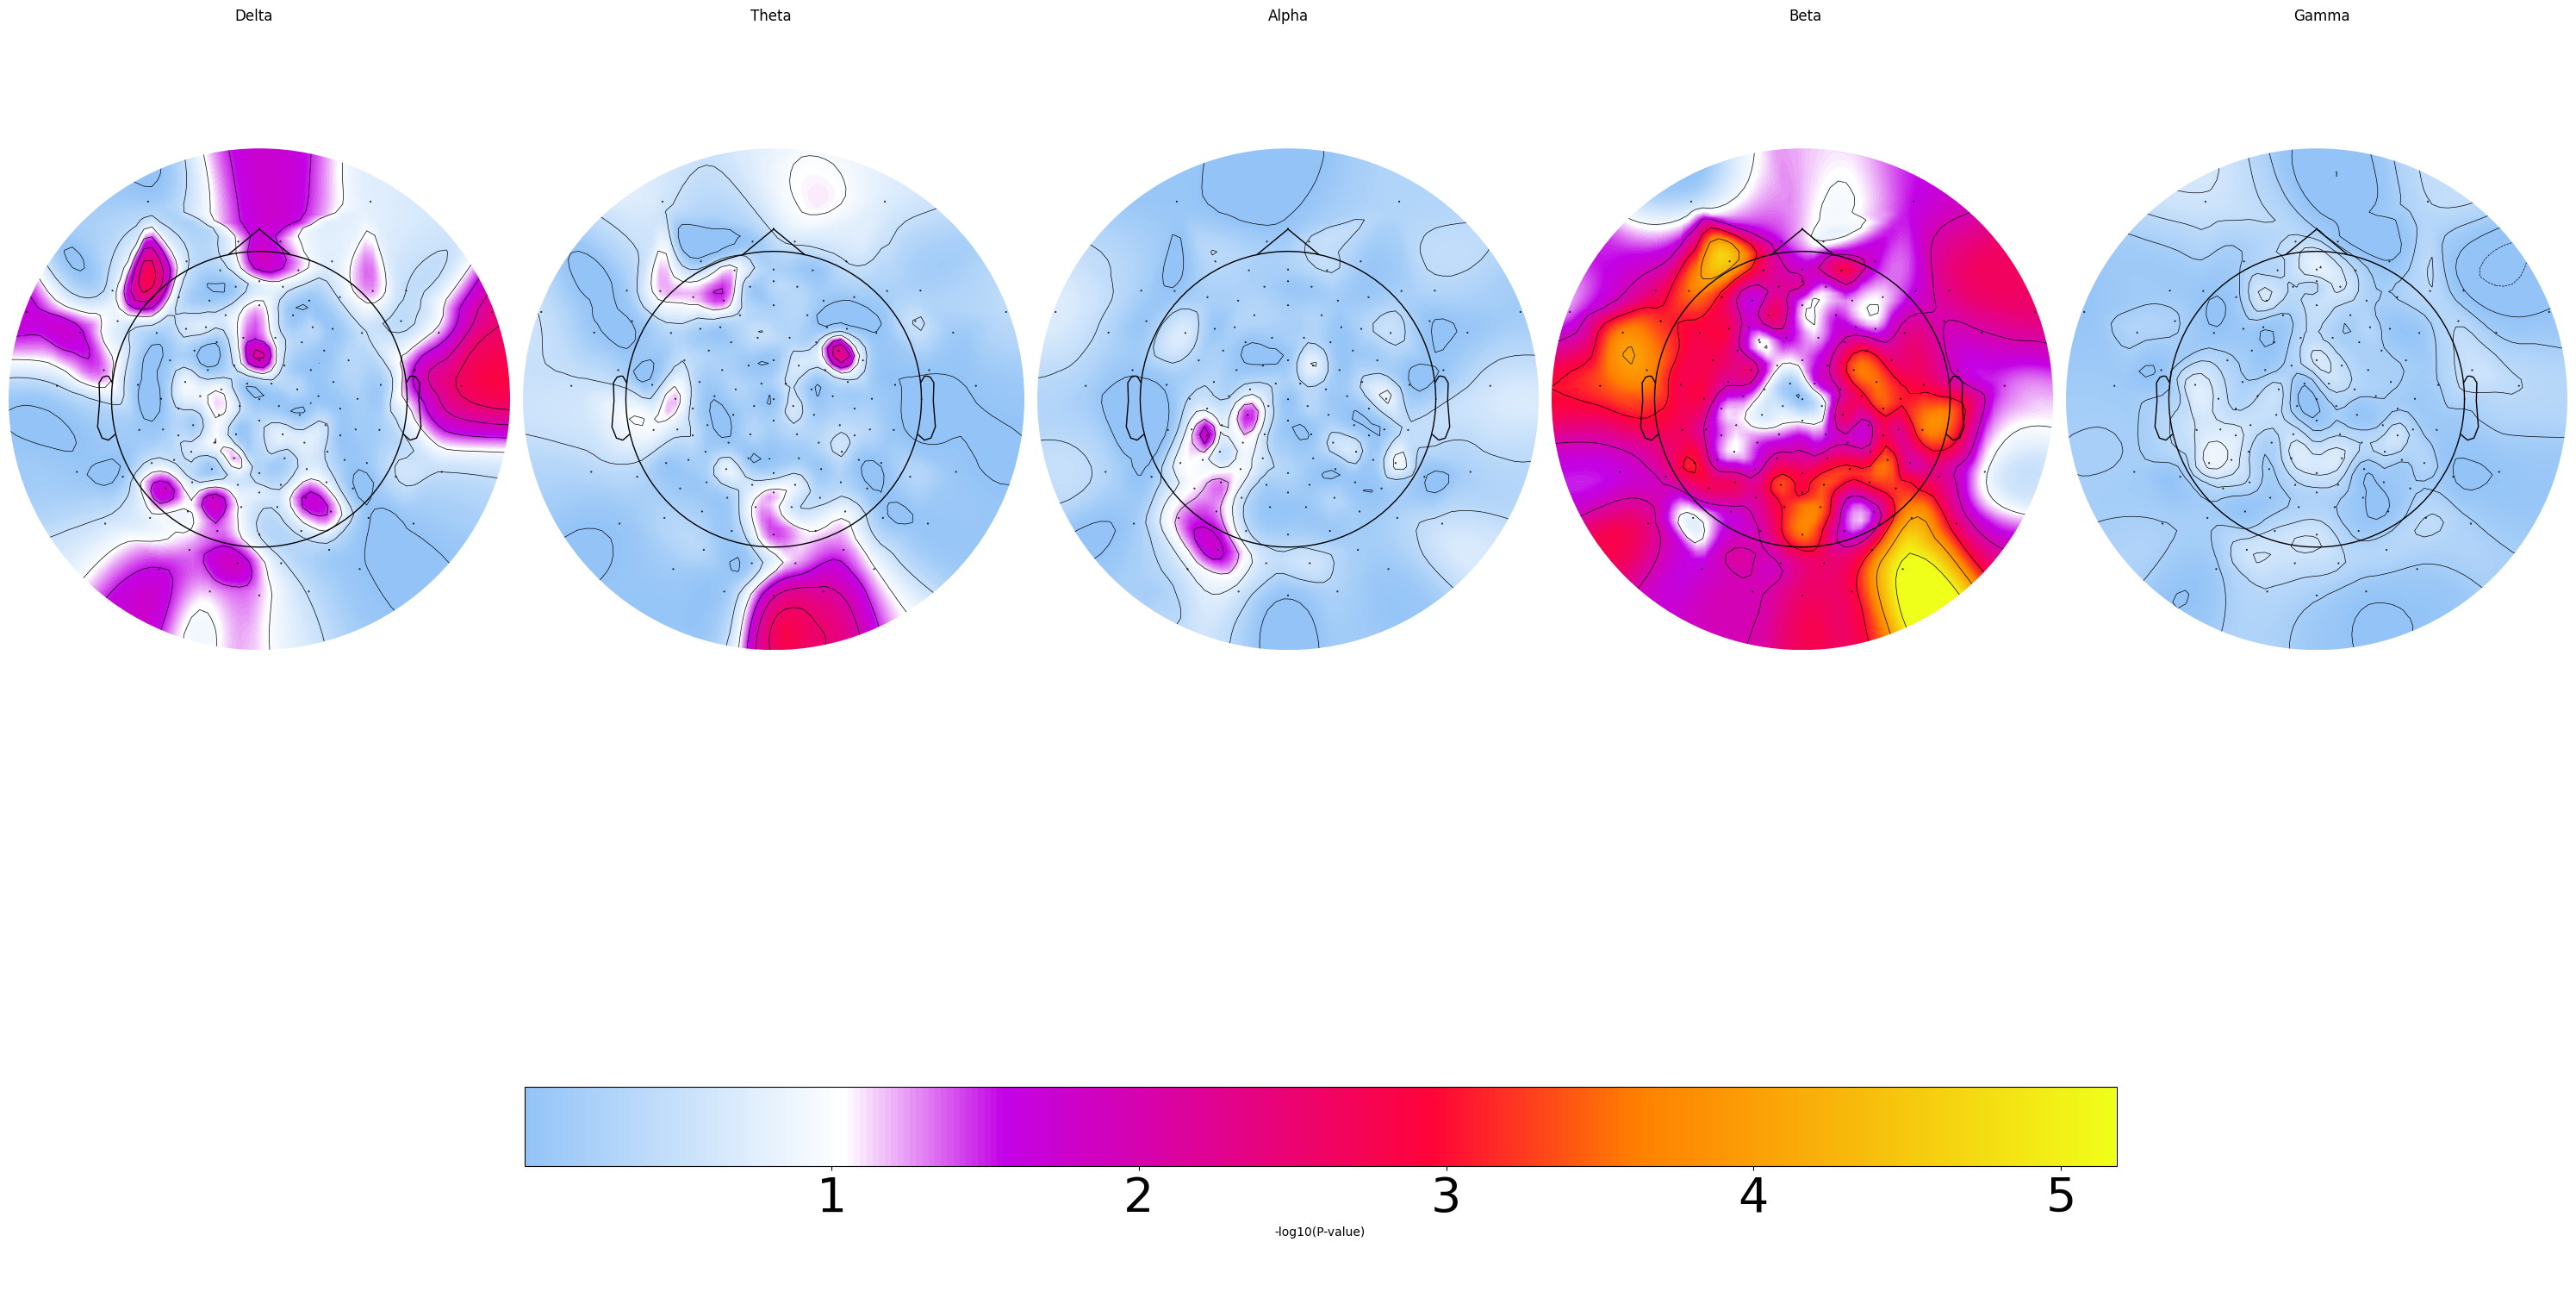

In [30]:
import matplotlib.colors as mcolors

weighted_x = electrode_band_sumcoef*xi

mean = np.mean(electrode_band_sumcoef)
std_dev = np.std(electrode_band_sumcoef)
standardized_w = (electrode_band_sumcoef - mean) / std_dev

mean = np.mean(xi)
std_dev = np.std(xi)
standardized_xi = (xi - mean) / std_dev

stand_weighted_x = standardized_w*standardized_xi

diagnosis = np.load('NEW_INPUTS/diagnoses.npy')
ASD_weighted_x = stand_weighted_x[diagnosis==1]
CON_weighted_x = stand_weighted_x[diagnosis==0]

t_values = np.zeros((128, 5))
p_values = np.zeros((128, 5))


for i in range(128):
    for j in range(5):
        sample1 = ASD_weighted_x[:, i, j]
        sample2 = CON_weighted_x[:, i, j]
        t_stat, p_val = ttest_ind(sample1, sample2, equal_var=False)  # equal_var=False for Welch's t-test
        t_values[i, j] = t_stat
        p_values[i, j] = p_val

neg_log_pval = -np.log10(p_values)

fig, axs = plt.subplots(2, 5, figsize=(30, 15))

band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

vmin, vmax = np.min(neg_log_pval), np.max(neg_log_pval)
cvals  = [0, 0.2, 0.3, 0.57, 0.7, 1]
norm=plt.Normalize(min(cvals),max(cvals))
print(vmax)

colors = ["#0d1d3d","#7b1e8a", "#e637bd","#e5ff00"]
colors = ["#021852","#2d02ad", "#c302e6","#ff0339", "#ff8000", "#f0ff19"]
colors = ["#94c4f7","#ffffff", "#c302e6","#ff0339", "#ff8000", "#f0ff19"]

tuples = list(zip(map(norm,neg_log_pval), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(cvals, colors)))

for band in range(5):
    feat_importance = np.append(neg_log_pval[:,band], 0)
    mne.viz.plot_topomap(feat_importance, pos=raw.info, cmap=cmap,axes=axs[0,band], show=False, vlim=((vmin,vmax))) 

for band in range(5):
    fig.text((band+0.5)/5, 1, f'{band_names[band]}', ha='center', va='center', fontsize=12)

for i in range(5):
    axs[1, i].axis('off')
    
i = 4
key = fig.colorbar(axs[0, i].images[0], ax=axs, orientation='horizontal', fraction=0.08, pad=0.04)
key.set_label("-log10(P-value)")
key.ax.tick_params(labelsize=40)

plt.tight_layout()
plt.show()

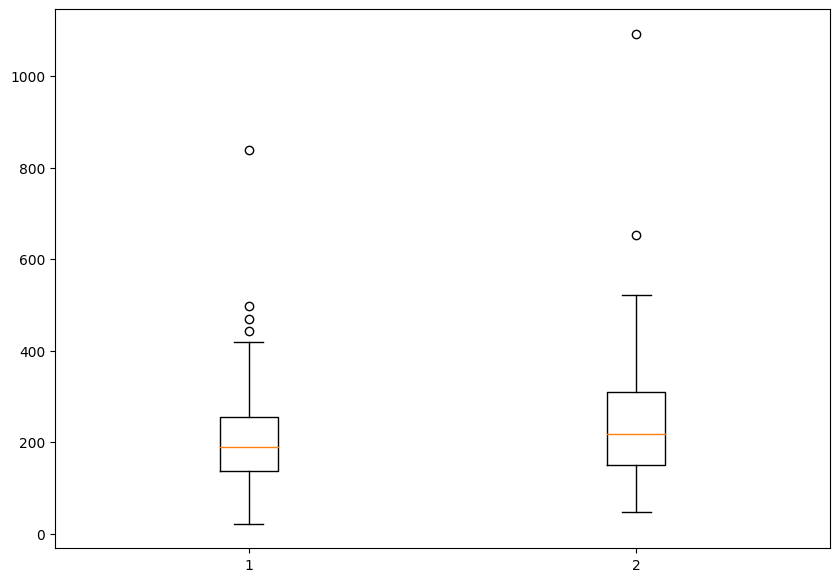

In [329]:
across_trial = np.load('Week4_arrays/AcrossTrial_PSDfeatures.npy')
across_trial_ASD = across_trial[diagnosis==1]
across_trial_CON = across_trial[diagnosis==0]

ASD = np.sum(across_trial_ASD[:,0,3:4,:,:].reshape(94, -1),axis=1)
CON = across_trial_CON[:,0,3:4,:,:].reshape(96, -1).sum(1)

fig = plt.figure(figsize =(10, 7))

plt.boxplot([ASD, CON])

plt.show()

# x = across_trial_ASD[:,1,:,:,:]-across_trial_CON[:,1,:,:,:][:94]
# print(np.sum(x>0))
# print(np.sum(x<0))

# print(np.mean(x), np.std(x))

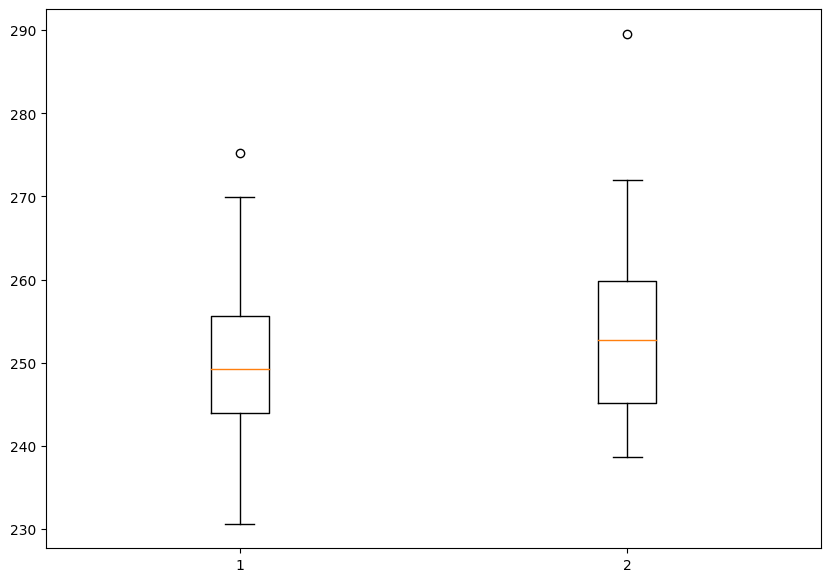

In [253]:
indices = top_indices_arr
ASD = np.sum(across_trial_ASD[:, indices[0], indices[1], indices[2], indices[3]], axis=1)
CON = np.sum(across_trial_CON[:, indices[0], indices[1], indices[2], indices[3]], axis=1)
fig = plt.figure(figsize =(10, 7))

plt.boxplot([ASD, CON])

plt.show()

In [227]:
np.where(across_trial_ASD[:,1,:,:,:]<0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

# Accuracy plots

In [107]:
x = pd.read_csv('FINALRESULTS.csv')
def process_string_representation(string_representation):
    formatted_string = string_representation.replace('array(', '[').replace(')', ']')
    list_of_lists = ast.literal_eval(formatted_string)
    numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
    arr2 = np.concatenate(numpy_arrays_list).flatten()
    
    return arr2

def process_string_representation2(string_representation):
    list_of_floats = ast.literal_eval(string_representation)
    arr2 = np.array(list_of_floats)
    
    return arr2



# x['all_accuracy_arr'] = x['all_accuracy'].apply(process_string_representation)
x['all_accuracy_arr'] = x['all_f1_score'].apply(process_string_representation2)

x = x[['model_name', 'feature_type', 'all_accuracy_arr']]

x = x[x['feature_type'].isin(['AcrossTrial', 'MeanEEG'])]
categories = ["LR", "RF", "SVC", "ANN"]
x['model_name'] = pd.Categorical(x['model_name'], categories=categories, ordered=True)
sorted_x = x.sort_values(by='model_name')
sorted_x = sorted_x.reset_index(drop=True)
sorted_x

,model_name,feature_type,all_accuracy_arr
0,LR,AcrossTrial,"[0.7083333333333334, 0.5454545454545454, 0.606..."
1,LR,MeanEEG,"[0.6511627906976744, 0.5161290322580646, 0.611..."
2,RF,AcrossTrial,"[0.6976744186046512, 0.4666666666666667, 0.648..."
3,RF,MeanEEG,"[0.4571428571428571, 0.5789473684210527, 0.555..."
4,SVC,AcrossTrial,"[0.6511627906976745, 0.5555555555555556, 0.648..."
5,SVC,MeanEEG,"[0.5142857142857142, 0.42424242424242425, 0.59..."
6,ANN,AcrossTrial,"[0.7547169811320755, 0.5405405405405406, 0.647..."
7,ANN,MeanEEG,"[0.6666666666666666, 0.6666666666666666, 0.702..."


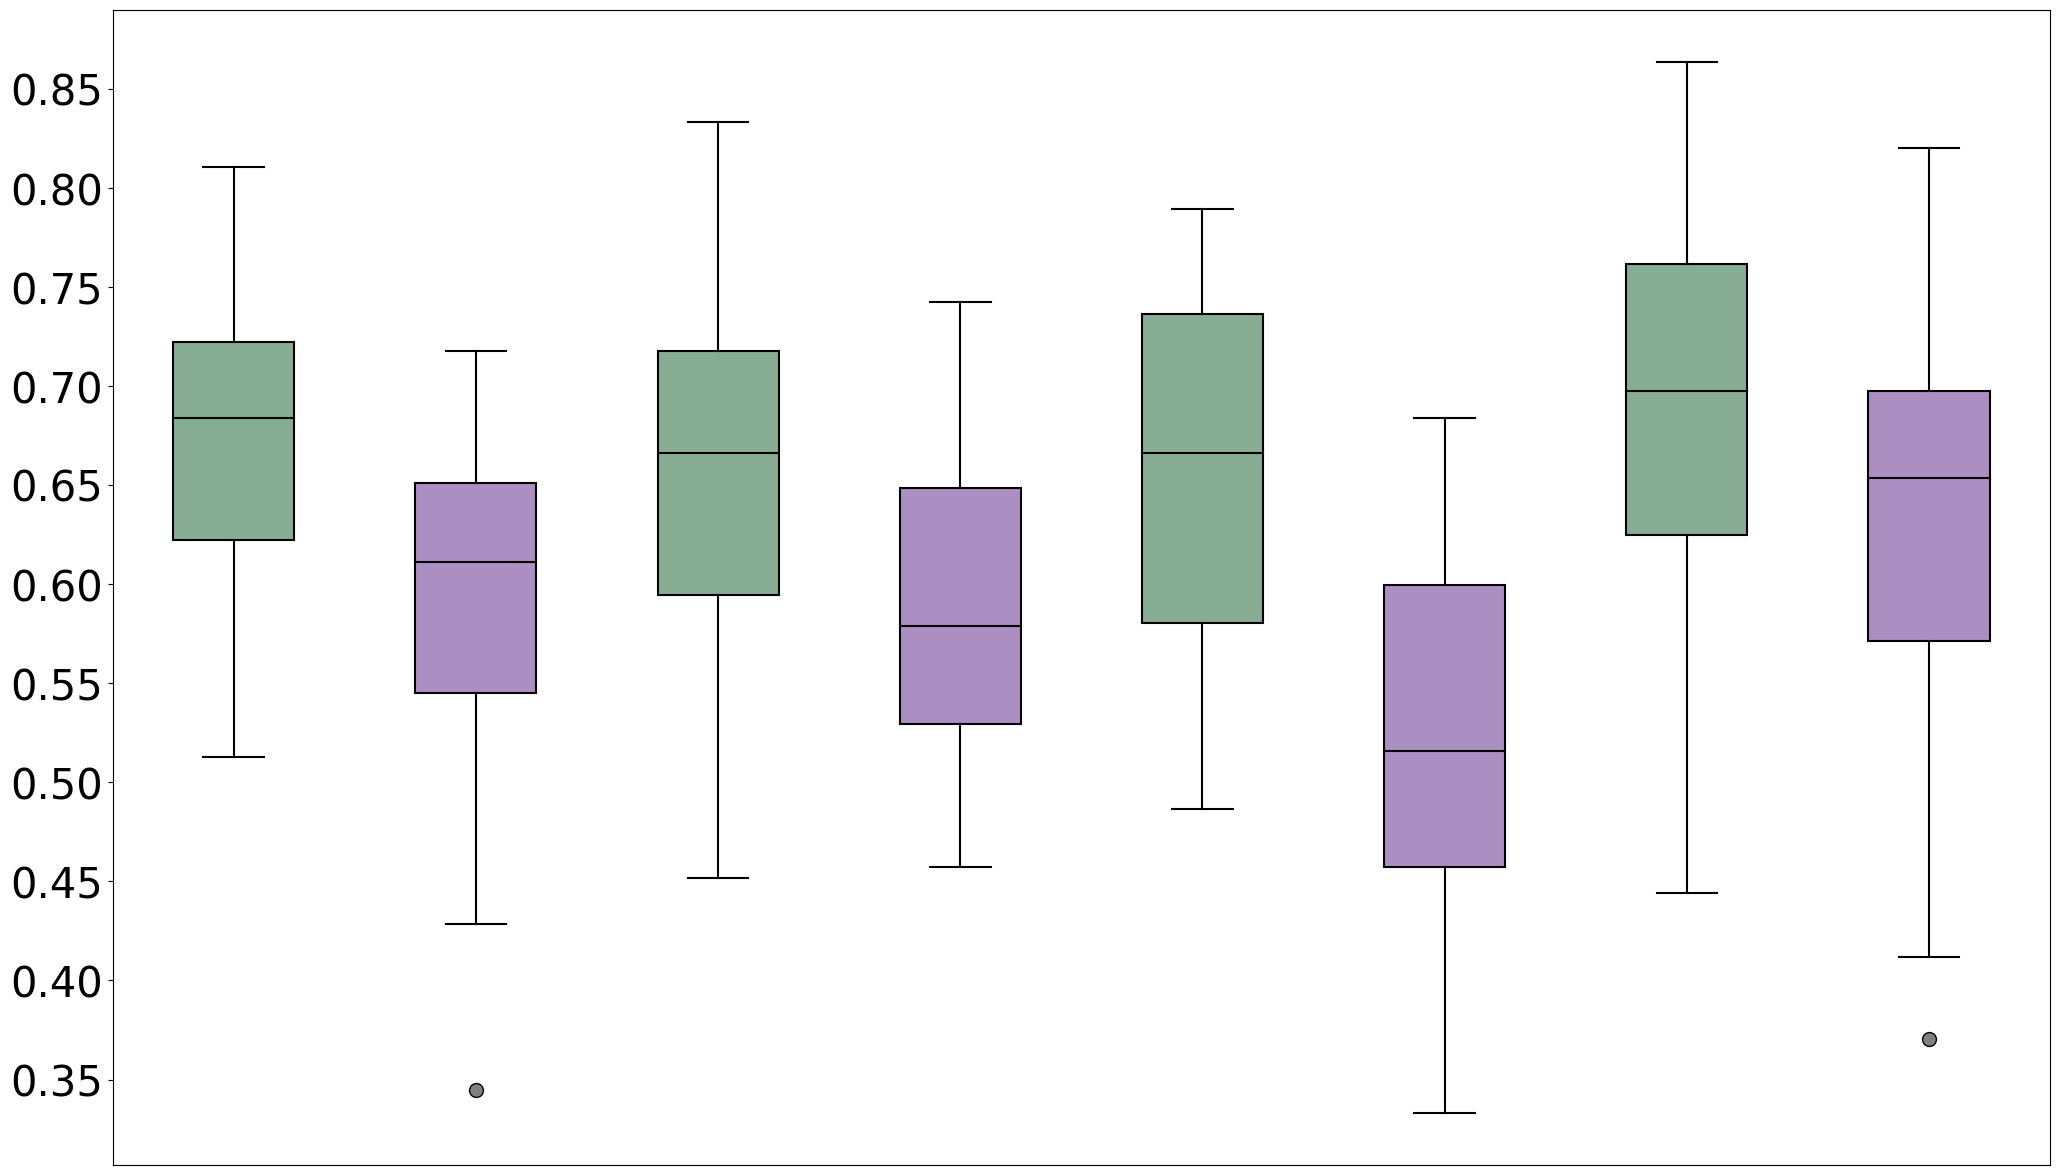

In [108]:
expanded_df = sorted_x.explode('all_accuracy_arr').reset_index(drop=True)
expanded_df['plot_index'] = expanded_df.index // len(sorted_x['all_accuracy_arr'][0])

colors = ['#86ad94', '#ac8fc2'] * (len(x) // 2)

data = [expanded_df.loc[expanded_df['plot_index'] == i, 'all_accuracy_arr'] for i in range(len(sorted_x))]

plt.figure(figsize=(25, 15))
box = plt.boxplot(data, patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color) 
    patch.set_edgecolor('black') 
    
for line in box['medians']:
    line.set_linewidth(1.5)
    line.set_color('black')
    
for line in box['whiskers']:
    line.set_linewidth(1.5)
    line.set_color('black')


for line in box['caps']:
    line.set_linewidth(1.5)
    line.set_color('black')

for line in box['boxes']:
    line.set_linewidth(1.5) 
    line.set_edgecolor('black') 


for line in box['fliers']:
    line.set_markerfacecolor('gray') 
    line.set_markeredgecolor('black')
    line.set_marker('o')  
    line.set_markersize(10) 
    
plt.xticks([])

plt.yticks(fontsize=30) 

# Set y-tick frequency
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))

In [56]:
expanded_df

,model_name,feature_type,all_accuracy_arr,plot_index
2,LR,AcrossTrial,0.708333,0
2,LR,AcrossTrial,0.545455,0
2,LR,AcrossTrial,0.606061,0
2,LR,AcrossTrial,0.714286,0
2,LR,AcrossTrial,0.666667,0
...,...,...,...,...
15,ANN,MeanEEG,0.571429,7
15,ANN,MeanEEG,0.711111,7
15,ANN,MeanEEG,0.820513,7
15,ANN,MeanEEG,0.615385,7


# ANN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

def create_ann_model():
    
# FOR ACROSS-TRIAL
    model = Sequential()


    model.add(Dense(4096, input_shape=(x.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())

    # model.add(Dense(16, activation='relu'))
    # model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


ann_model = KerasClassifier(build_fn=create_ann_model, epochs=10, batch_size=32, verbose=1)


In [53]:
def create_ann_model():
    model = Sequential()

#FOR MEAN_EEG
    model.add(Dense(2048, input_shape=(x.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())

    # model.add(Dense(16, activation='relu'))
    # model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


ann_model = KerasClassifier(build_fn=create_ann_model, epochs=10, batch_size=32, verbose=1)


# Correlation

In [35]:
df = pd.read_csv('NEW_RESULTS/FINALRESULTS.csv')

In [37]:
def process_string_representation(string_representation):
    formatted_string = string_representation.replace('array(', '[').replace(')', ']')
    list_of_lists = ast.literal_eval(formatted_string)
    numpy_arrays_list = [np.array(arr) for arr in list_of_lists]
    arr2 = np.concatenate(numpy_arrays_list).flatten()
    
    return arr2

def process_string_representation2(string_representation):
    list_of_floats = ast.literal_eval(string_representation)
    arr2 = np.array(list_of_floats)
    
    return arr2


In [38]:
df['all_accuracy_arr'] = df['all_accuracy'].apply(process_string_representation)


In [43]:
df['all_f1_score_arr'] = df['all_f1_score'].apply(process_string_representation2)

In [44]:
df['all_precision_arr'] = df['all_precision'].apply(process_string_representation2)
df['all_recall_arr'] = df['all_recall'].apply(process_string_representation2)
df['all_specificity_arr'] = df['all_specificity'].apply(process_string_representation2)
df['all_auroc_arr'] = df['all_auroc'].apply(process_string_representation2)
df['all_auprc_arr'] = df['all_auprc'].apply(process_string_representation2)

In [46]:
df.to_csv('FINALRESULTS_ARR_VERSION.csv')

In [50]:
array_row_0 = df.loc[0, 'all_accuracy_arr']
array_row_1 = df.loc[1, 'all_accuracy_arr']
correlation_coefficient = np.corrcoef(array_row_0, array_row_1)[0, 1]
correlation_coefficient

0.5462084129225543

In [54]:
x = df
x = x[x['feature_type'].isin(['AcrossTrial', 'MeanEEG'])]
categories = ["LR", "RF", "SVC", "ANN"]
x['model_name'] = pd.Categorical(x['model_name'], categories=categories, ordered=True)
sorted_x = x.sort_values(by='model_name')
sorted_x = sorted_x.reset_index(drop=True)
sorted_x

,accuracy,f1_score,precision,recall,specificity,auroc,auprc,model_name,feature_type,all_accuracy,...,all_specificity,all_auroc,all_auprc,all_accuracy_arr,all_f1_score_arr,all_precision_arr,all_recall_arr,all_specificity_arr,all_auroc_arr,all_auprc_arr
0,"(0.678, 0.083)","(0.678, 0.083)","(0.674, 0.101)","(0.693, 0.108)","(0.664, 0.123)","(0.748, 0.073)","(0.751, 0.086)",LR,AcrossTrial,"[array([0.63157895, 0.60526316, 0.65789474, 0....",...,"[0.4666666666666667, 0.7368421052631579, 0.681...","[0.7246376811594203, 0.7036011080332409, 0.732...","[0.8511925156447359, 0.7076011305416339, 0.668...","[0.63157895, 0.60526316, 0.65789474, 0.6842105...","[0.7083333333333334, 0.5454545454545454, 0.606...","[0.68, 0.6428571428571429, 0.5882352941176471,...","[0.7391304347826086, 0.47368421052631576, 0.62...","[0.4666666666666667, 0.7368421052631579, 0.681...","[0.7246376811594203, 0.7036011080332409, 0.732...","[0.8511925156447359, 0.7076011305416339, 0.668..."
1,"(0.608, 0.06)","(0.597, 0.088)","(0.601, 0.082)","(0.604, 0.117)","(0.61, 0.085)","(0.648, 0.07)","(0.678, 0.084)",LR,MeanEEG,"[array([0.60526316, 0.60526316, 0.63157895, 0....",...,"[0.6, 0.7894736842105263, 0.5909090909090909, ...","[0.5913043478260869, 0.670360110803324, 0.6875...","[0.7541263588600421, 0.6962347983400614, 0.670...","[0.60526316, 0.60526316, 0.63157895, 0.5789473...","[0.6511627906976744, 0.5161290322580646, 0.611...","[0.7, 0.6666666666666666, 0.55, 0.571428571428...","[0.6086956521739131, 0.42105263157894735, 0.68...","[0.6, 0.7894736842105263, 0.5909090909090909, ...","[0.5913043478260869, 0.670360110803324, 0.6875...","[0.7541263588600421, 0.6962347983400614, 0.670..."
2,"(0.66, 0.085)","(0.646, 0.102)","(0.665, 0.112)","(0.649, 0.147)","(0.681, 0.121)","(0.742, 0.082)","(0.744, 0.089)",RF,AcrossTrial,"[array([0.65789474, 0.57894737, 0.65789474, 0....",...,"[0.6666666666666666, 0.7894736842105263, 0.590...","[0.7014492753623188, 0.6966759002770083, 0.742...","[0.8068809526215612, 0.7165280639995903, 0.708...","[0.65789474, 0.57894737, 0.65789474, 0.6052631...","[0.6976744186046512, 0.4666666666666667, 0.648...","[0.75, 0.6363636363636364, 0.5714285714285714,...","[0.6521739130434783, 0.3684210526315789, 0.75,...","[0.6666666666666666, 0.7894736842105263, 0.590...","[0.7014492753623188, 0.6966759002770083, 0.742...","[0.8068809526215612, 0.7165280639995903, 0.708..."
3,"(0.614, 0.068)","(0.589, 0.076)","(0.626, 0.095)","(0.571, 0.109)","(0.662, 0.115)","(0.672, 0.092)","(0.693, 0.088)",RF,MeanEEG,"[array([0.5 , 0.57894737, 0.57894737, 0....",...,"[0.7333333333333333, 0.5789473684210527, 0.545...","[0.5173913043478261, 0.6509695290858727, 0.680...","[0.689595348508392, 0.6792787822199586, 0.6925...","[0.5, 0.57894737, 0.57894737, 0.65789474, 0.52...","[0.4571428571428571, 0.5789473684210527, 0.555...","[0.6666666666666666, 0.5789473684210527, 0.5, ...","[0.34782608695652173, 0.5789473684210527, 0.62...","[0.7333333333333333, 0.5789473684210527, 0.545...","[0.5173913043478261, 0.6509695290858727, 0.680...","[0.689595348508392, 0.6792787822199586, 0.6925..."
4,"(0.659, 0.079)","(0.656, 0.089)","(0.659, 0.101)","(0.679, 0.146)","(0.654, 0.106)","(0.734, 0.087)","(0.743, 0.093)",SVC,AcrossTrial,"[array([0.60526316, 0.57894737, 0.65789474, 0....",...,"[0.6, 0.631578947368421, 0.5909090909090909, 0...","[0.6768115942028985, 0.6371191135734071, 0.698...","[0.7726132914033079, 0.6823777329572098, 0.619...","[0.60526316, 0.57894737, 0.65789474, 0.7105263...","[0.6511627906976745, 0.5555555555555556, 0.648...","[0.7, 0.5882352941176471, 0.5714285714285714, ...","[0.6086956521739131, 0.5263157894736842, 0.75,...","[0.6, 0.631578947368421, 0.5909090909090909, 0...","[0.6768115942028985, 0.6371191135734071, 0.698...","[0.7726132914033079, 0.6823777329572098, 0.619..."
5,"(0.577, 0.064)","(0.532, 0.087)","(0.608, 0.136)","(0.509, 0.161)","(0.669, 0.146)","(0.608, 0.115)","(0.619, 0.102)",SVC,MeanEEG,"[array([0.55263158, 0.5 , 0.60526316, 0....",...,"[0.8, 0.6315789473684

In [59]:
last_7= df.iloc[-7:, -7:]

first = df.iloc[0, -7:]

result_array = np.zeros((7, 7, 2))

for i in range(7):
    for j in range(7):
        array1 = last_7.iloc[i, j]
        array2 = first.iloc[j]
        
        if len(array1) == len(array2):
            correlation_coefficient = np.corrcoef(array1, array2)[0, 1]
            result_array[i, j, 0] = correlation_coefficient

            mse = mean_squared_error(array1, array2)
            rmse = np.sqrt(mse)
            result_array[i, j, 1] = rmse
        else:
            result_array[i, j, 0] = np.nan  # or some other placeholder value
            result_array[i, j, 1] = np.nan  # or some other placeholder value

In [60]:
result_array

array([[[0.19526203, 0.12773328],
        [0.22311001, 0.12519907],
        [0.42110831, 0.16026835],
        [0.41106992, 0.12516791],
        [0.20292675, 0.18295758],
        [0.2312286 , 0.1540657 ],
        [0.3725057 , 0.11626006]],

       [[0.23715415, 0.09385555],
        [0.27032772, 0.09774277],
        [0.43266926, 0.12763212],
        [0.29086553, 0.1232761 ],
        [0.08325391, 0.17343508],
        [0.4333469 , 0.10927813],
        [0.58723847, 0.11794054]],

       [[0.54438348, 0.09146393],
        [0.51850613, 0.10069018],
        [0.47027877, 0.12987027],
        [0.56191006, 0.12181433],
        [0.12505856, 0.16064365],
        [0.45940717, 0.1278722 ],
        [0.62171419, 0.09667163]],

       [[0.51068317, 0.08153649],
        [0.67589967, 0.08028599],
        [0.65800703, 0.09895508],
        [0.71640223, 0.16643034],
        [0.4852777 , 0.19880551],
        [0.69453708, 0.07727824],
        [0.74914731, 0.08079463]],

       [[0.7164454 , 0.05837124],
      

In [61]:
np.save('result_array.npy', result_array)